In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob  
import numpy as np  
from skimage.io import imread 
from skimage.transform import resize 
import cv2
import seaborn as sns 
# For reproducibility
np.random.seed(42)

import fnmatch
import os
import pickle as pkl



from sklearn import metrics
import sklearn
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay,f1_score, 
                             recall_score, precision_score, balanced_accuracy_score, RocCurveDisplay)
from sklearn.utils import class_weight

import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from keras.utils import image_dataset_from_directory
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2



In [3]:
#Code adapted from : https://colab.research.google.com/notebooks/snippets/drive.ipynb#scrollTo=TbRbQAYqPTci

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [4]:
train_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/train_2_reshapedImg_labels3_b.csv')
train_label_df.head()

,image_id,label,level,label_b
0,10003_left,0,No DR,0
1,10003_right,0,No DR,0
2,10007_left,0,No DR,0
3,10007_right,0,No DR,0
4,10009_left,0,No DR,0


In [5]:
test_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/test_reshapedImg_labels_b.csv')
test_label_df.head()

,image_id,label,level,label_b
0,29127_left,0,No DR,0
1,29127_right,0,No DR,0
2,29132_left,0,No DR,0
3,29132_right,0,No DR,0
4,29135_left,0,No DR,0


In [6]:
index_to_level={0:'No DR', 1:'Mild DR',2:'Moderate DR',3:'Severe DR',4:'Proliferative DR'}
index_to_level

{0: 'No DR',
 1: 'Mild DR',
 2: 'Moderate DR',
 3: 'Severe DR',
 4: 'Proliferative DR'}

In [7]:
# for images, labels in train.take(1):
#   print(np.max(images[0]))

In [8]:
# help from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=iscU3UoVJBXj

# AUTOTUNE = tf.data.AUTOTUNE

# train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
test_true_class=test_label_df['label'].to_numpy()
print(len(test_true_class))
test_true_class

3822


array([0, 0, 0, ..., 0, 0, 0])

In [8]:
train_true_class=train_label_df['label'].to_numpy()
print(len(train_true_class))
train_true_class;

28860


In [9]:
def gety(train):
  for image, label in train:
    y=label.numpy()
  return y

In [10]:
# https://stackoverflow.com/questions/67448748/insert-nan-if-key-is-missing-in-dictionary
def get_weights(train):
  weights=class_weight.compute_class_weight(class_weight='balanced',
                                    classes=np.unique(gety(train)), 
                                    y=gety(train))
  classes=np.unique(gety(train))
  weights_dict=dict(zip(classes, weights))

  weights_dict_empty={0:1,1:1,2:1,3:1,4:1}
  weights_dict_final = {key: weights_dict.get(key, float(1)) for key in weights_dict_empty}


  return weights_dict_final
                            

In [11]:
weights_master=class_weight.compute_class_weight(class_weight='balanced',
                                    classes=np.unique(np.array(train_label_df['label'])), 
                                    y=np.array(train_label_df['label']))
classes_master=np.unique(np.array(train_label_df['label']))
weights_dict_master=dict(zip(classes_master, weights_master))
weights_dict_master

{0: 0.271253348371634,
 1: 2.9210526315789473,
 2: 1.3339496186734459,
 3: 8.095371669004207,
 4: 10.215929203539822}

In [12]:
weights_b_master=class_weight.compute_class_weight(class_weight='balanced',
                                    classes=np.unique(np.array(train_label_df['label_b'])), 
                                    y=np.array(train_label_df['label_b']))
classes_b_master=np.unique(np.array(train_label_df['label_b']))
weights_b_dict_master=dict(zip(classes_b_master, weights_b_master))
weights_b_dict_master

{0: 0.678133370929085, 1: 1.9034428175702414}

In [13]:
def plot_history(history):
  plt.figure(figsize=(10,10))
  metrics = ['loss','acc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='r', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    

  return

In [14]:
eval_df=pd.DataFrame(columns=['class','precision','recall','f1-score','support','model_no','comment'])

In [17]:
# eval_df.to_csv('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model_evaluation.csv', index=False)

In [15]:


def model_eval2(model, model_no, comment, test, val):
  eval_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model_evaluation.csv')
  print('-----TEST--------')
  weighted_results = model.evaluate(test, verbose=1)
  for name, value in zip(model.metrics_names, weighted_results):
    print(name, ': ', value)
  print('-------------')


  print('-----VAL--------')
  # val_true_class_b=get_label(val)
  weighted_results = model.evaluate(val, verbose=1)
  for name, value in zip(model.metrics_names, weighted_results):
    print(name, ': ', value)
  print('-------------')

  test_pred_class=np.argmax(model.predict(test), axis=1)
  print(len(test_pred_class))
  # print(tf.math.confusion_matrix(labels=test_true_class, predictions=test_pred_class, num_classes=5))


  print(classification_report(test_true_class, test_pred_class,  zero_division=0))

  
  cm = tf.math.confusion_matrix(labels=test_true_class, predictions=test_pred_class, num_classes=5)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

  report=classification_report(test_true_class, test_pred_class, zero_division=0, output_dict=True)
  report_df=pd.DataFrame(report)
  report_df=report_df.transpose()
  report_df.reset_index(inplace=True)
  report_df.rename(columns={'index':'class'},inplace=True)
  report_df['model_no']=model_no
  report_df['comment']=comment
 
  #saving metrics
  eval_df=pd.concat([eval_df,report_df], axis=0);

  eval_df.to_csv('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model_evaluation.csv',index=False)
  return eval_df

In [ ]:
# #train val loss over epochs
# def loss_plot(history):
#   train_loss=history.history['loss']
#   val_loss=history.history['val_loss']

#   train_accuracy=history.history['accuracy']
#   val_accuracy=history.history['val_accuracy']

#   epoch_labels=history.epoch

#   plt.figure(figsize=(10,8))

#   for i in range(2):
#     ax = plt.subplot(1, 2, i + 1)
#     if i==1:
#       plt.plot(train_loss, label='Training loss',color='#185fad')
#       plt.plot(val_loss, label='Validation loss', color='orange')
#       plt.title('Training and Validation loss\n by Epoch', fontsize=16)
#       plt.ylabel('Categorical Crossentropy', fontsize=14)
#     else:
#       plt.plot(train_accuracy, label='Training Accuracy',color='#185fad')
#       plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
#       plt.title('Training and Validation Accuracy\n by Epoch', fontsize=16)
#       plt.ylabel('Accuracy', fontsize=14)

#     plt.xlabel('Epoch',fontsize=14)
#     plt.xticks(range(0, int(max(epoch_labels)), 2), rotation=90)
#     plt.legend(fontsize=18);
    

  # return

In [ ]:
# def model_eval(model, model_name):
#   train_score=model.evaluate(train,
#                             verbose=1)
#   val_score=model.evaluate(val,
#                           verbose=1)
#   test_score=model.evaluate(test,
#                             verbose=1)
#   model_labels=model.metrics_names

#   print(f'{model_name}, train {model_labels[0]}: {train_score[0]}')
#   print(f'{model_name}, train {model_labels[1]}: {train_score[1]}')
  
#   print(f'{model_name}, val {model_labels[0]}: {val_score[0]}')
#   print(f'{model_name}, val {model_labels[1]}: {val_score[1]}')

  
#   print(f'{model_name}, test {model_labels[0]}: {test_score[0]}')
#   print(f'{model_name}, test {model_labels[1]}: {test_score[1]}')

#   test_pred_class=np.argmax(model.predict(test), axis=1)
#   print(tf.math.confusion_matrix(labels=test_true_class, predictions=test_pred_class, num_classes=5))

#   print(classification_report(test_true_class, test_pred_class))

#   return

# Modeling with Original Data set

In [ ]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

#creating train and val batches 

data_dir='/content/drive/MyDrive/GA/Capstone/train'
IMG_height = 224
IMG_width = 224
batch_size=512


train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=train_label_df['label'].to_numpy().tolist(),
  label_mode='int',
  # class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="training",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)
 
val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=train_label_df['label'].to_numpy().tolist(),
  label_mode='int',
  # class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="validation",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)



Found 28860 files belonging to 1 classes.
Using 23088 files for training.
Found 28860 files belonging to 1 classes.
Using 5772 files for validation.


In [ ]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

# creating test batch

data_dir='/content/drive/MyDrive/GA/Capstone/test_train_3/test_reshapedImg_parent'
IMG_height = 224
IMG_width = 224
batch_size=512




test = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=test_label_df['label'].to_numpy().tolist(),
  label_mode='int',
  validation_split=0.0,
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)



Found 3822 files belonging to 1 classes.


In [ ]:
class_names = train.class_names
print(class_names)

['train_2_reshapedImg']


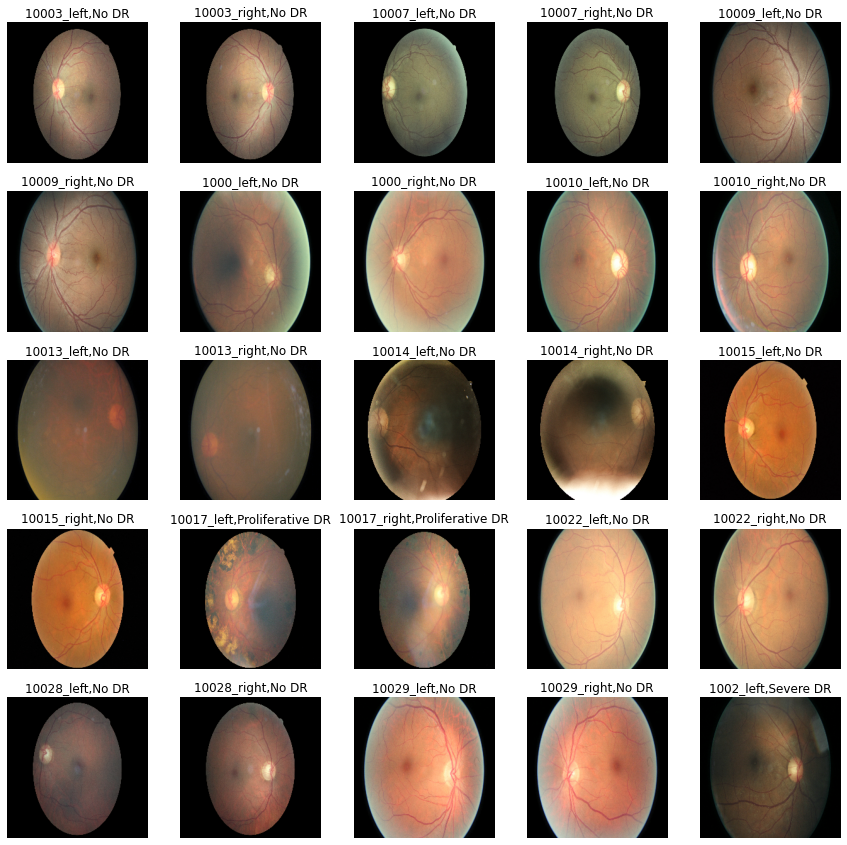

In [ ]:
#showing some train images

plt.figure(figsize=(15, 15))
for images, labels in train.take(1):
  file_paths = train.file_paths
  lbl=labels.numpy()
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{str(file_paths[i].rsplit('.',1)[0].rsplit('_',1)[0].rsplit('/',1)[1])},{index_to_level[lbl[i]]}")
    plt.axis("off")

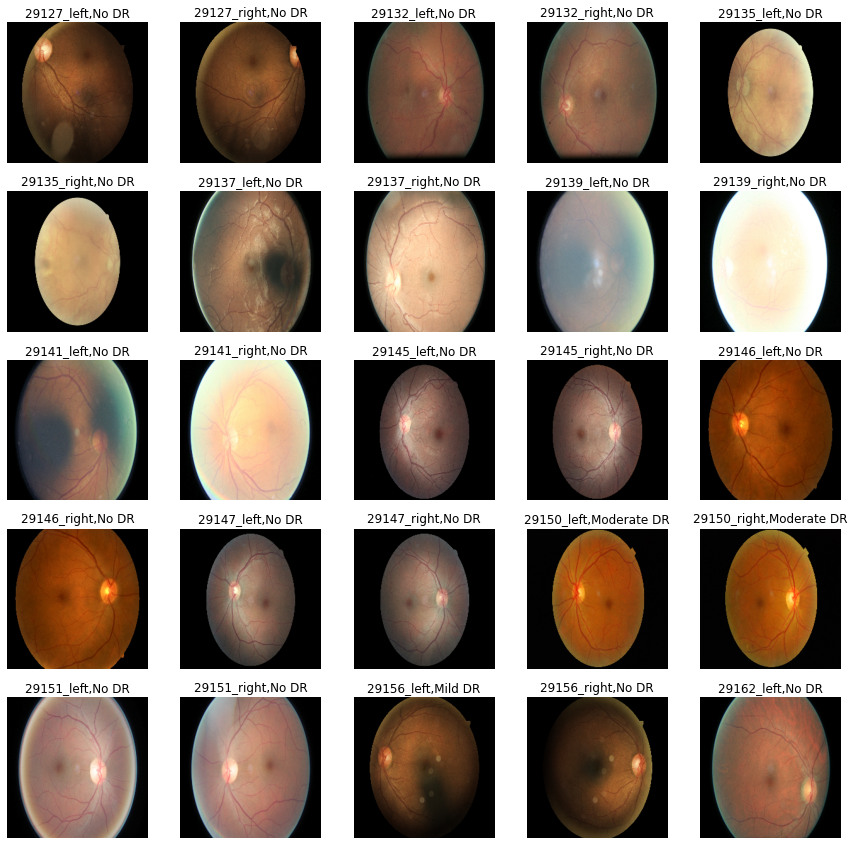

In [ ]:
#showing some test images

plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
  file_paths = test.file_paths
  lbl=labels.numpy()
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{str(file_paths[i].rsplit('.',1)[0].rsplit('_',1)[0].rsplit('/',1)[1])},{index_to_level[lbl[i]]}")
    plt.axis("off")

In [ ]:
METRICS = [      
      # keras.metrics.FalseNegatives(name='fn')
      # keras.metrics.AUC(name='auc'),
      tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
]

In [ ]:
es=EarlyStopping( 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

## Baseline Accuracy

In [69]:
train_label_df['label'].value_counts(normalize=True)

0    0.737318
2    0.149931
1    0.068468
3    0.024705
4    0.019577
Name: label, dtype: float64

In [12]:
whole_dataset_baseline=0.74

Models trained on whole datset has a baseline accuracy of 0.74

## CNN 2

trained on (train1, train_2, train3)

In [ ]:


model2=Sequential()

# Add a convolutional layer.

model2.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))

model2.add(Conv2D(filters=16,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(32,
                  kernel_size = (3, 3),
                  activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))


model2.add(Conv2D(64,
                  kernel_size = (3, 3),
                  activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))


model2.add(Flatten())


model2.add(Dense(64,
                activation='relu'))
model2.add(Dropout(0.5))


model2.add(Dense(128,
                activation='relu'))
model2.add(Dropout(0.5))


model2.add(Dense(128,
                activation='relu'))
model2.add(Dropout(0.5))


model2.add(Dense(5,
                 activation='softmax'))


model2.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS,
              )


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)       

In [ ]:
history_model2 = model2.fit(train,
                            validation_data=val,
                            epochs=20,
                            verbose=1,
                            )

model2.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_history.pkl','wb') as model_history:
  pkl.dump(history_model2, model_history)

In [ ]:
model2=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_history.pkl','rb') as model_history:
  history_model2=pkl.load( model_history)

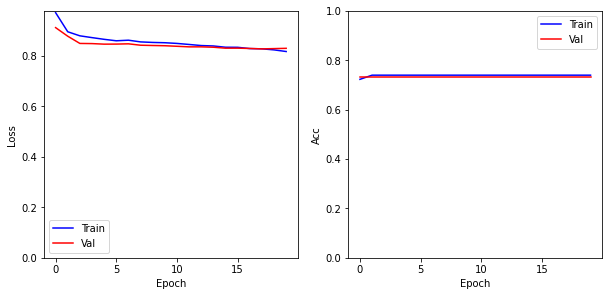

In [ ]:
plot_history(history_model2)


-----TEST--------
8/8 [==============================] - 18s 2s/step - loss: 0.8628 - acc: 0.7258
loss :  0.8628443479537964
acc :  0.7257980108261108
-------------
-----VAL--------
12/12 [==============================] - 25s 2s/step - loss: 0.8297 - acc: 0.7301
loss :  0.829657256603241
acc :  0.730076253414154
-------------
8/8 [==============================] - 17s 2s/step
3822
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      2774
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        83

    accuracy                           0.73      3822
   macro avg       0.15      0.20      0.17      3822
weighted avg       0.53      0.73      0.61      3822



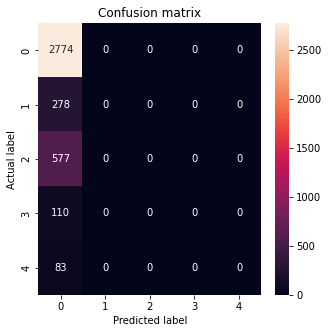

In [ ]:
eval_df=model_eval2(model2, 1, 'CNN2 whole dataset',test, val)

In [ ]:
eval_df

,class,precision,recall,f1-score,support,model_no,comment
0,0,0.725798,1.000000,0.841116,2774.000000,1,CNN2 whole dataset
1,1,0.000000,0.000000,0.000000,278.000000,1,CNN2 whole dataset
2,2,0.000000,0.000000,0.000000,577.000000,1,CNN2 whole dataset
3,3,0.000000,0.000000,0.000000,110.000000,1,CNN2 whole dataset
4,4,0.000000,0.000000,0.000000,83.000000,1,CNN2 whole dataset
5,accuracy,0.725798,0.725798,0.725798,0.725798,1,CNN2 whole dataset
6,macro avg,0.145160,0.200000,0.168223,3822.000000,1,CNN2 whole dataset
7,weighted avg,0.526783,0.725798,0.610480,3822.000000,1,CNN2 whole dataset


## CNN 3


with the whole train set (train_1, train_2, train_3, train_4)
and with wighted classes


In [ ]:
es=EarlyStopping(patience=10)

model3=Sequential()

# Add a convolutional layer.

model3.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))

model3.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model3.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model3.add(Conv2D(128,
                  kernel_size = (3, 3),
                  activation='relu'))
model3.add(Conv2D(128,
                  kernel_size = (1, 1),
                  activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model3.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model3.add(Conv2D(256,
                  kernel_size = (1, 1),
                  activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))


model3.add(Flatten())


model3.add(Dense(128,
                activation='relu', kernel_regularizer=l2(0.005)))
model3.add(Dropout(0.5))


model3.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model3.add(Dropout(0.5))


model3.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model3.add(Dropout(0.5))


model3.add(Dense(5,
                 activation='softmax'))


model3.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS,
              )

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                        

In [ ]:
history_model3 = model3.fit(train,
                            validation_data=val,
                            epochs=15,
                            verbose=1,
                            callbacks=[es],
                          )
                                                                              

model3.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3_history.pkl','wb') as model_history:
  pkl.dump(history_model3, model_history)



In [ ]:
model3=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3_history.pkl','rb') as model_history:
  history_model3=pkl.load( model_history)

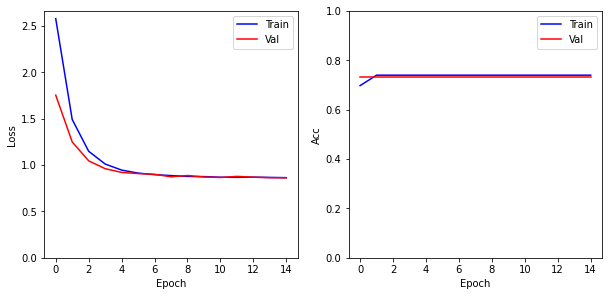

In [ ]:
plot_history(history_model3)

-----TEST--------
8/8 [==============================] - 257s 31s/step - loss: 0.8886 - acc: 0.7258
loss :  0.8885653018951416
acc :  0.7257980108261108
-------------
-----VAL--------
12/12 [==============================] - 378s 31s/step - loss: 0.8621 - acc: 0.7301
loss :  0.862126350402832
acc :  0.730076253414154
-------------
8/8 [==============================] - 260s 32s/step
3822
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      2774
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        83

    accuracy                           0.73      3822
   macro avg       0.15      0.20      0.17      3822
weighted avg       0.53      0.73      0.61      3822



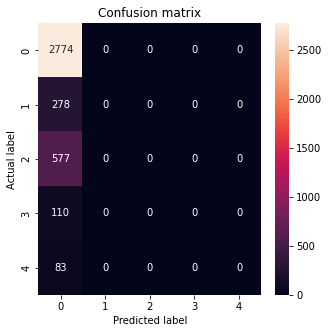

In [ ]:
eval_df=model_eval2(model3,2, 'CNN2 with more layers', test, val)

### CNN3 weighted

In [ ]:

history_model3Wt = model3.fit(train,
                            validation_data=val,
                            epochs=15,
                            verbose=1,
                            callbacks=[es],
                            class_weight = get_weights(train))



model3.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3Wt.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3Wt_history.pkl','wb') as model_history:
  pkl.dump(history_model3Wt, model_history)


In [ ]:
model3Wt=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3Wt.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3Wt_history.pkl','rb') as model_history:
  history_model3Wt=pkl.load( model_history)

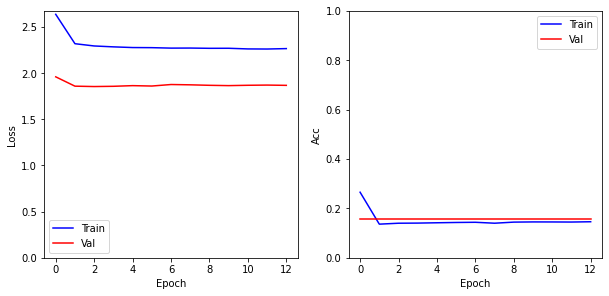

In [ ]:
plot_history(history_model3Wt)

-----TEST--------
8/8 [==============================] - 356s 43s/step - loss: 1.9031 - acc: 0.1510
loss :  1.9031453132629395
acc :  0.15096807479858398
-------------
-----VAL--------
12/12 [==============================] - 476s 39s/step - loss: 1.8669 - acc: 0.1551
loss :  1.8669286966323853
acc :  0.15505890548229218
-------------
8/8 [==============================] - 237s 29s/step
3822
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2774
           1       0.00      0.00      0.00       278
           2       0.15      1.00      0.26       577
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        83

    accuracy                           0.15      3822
   macro avg       0.03      0.20      0.05      3822
weighted avg       0.02      0.15      0.04      3822



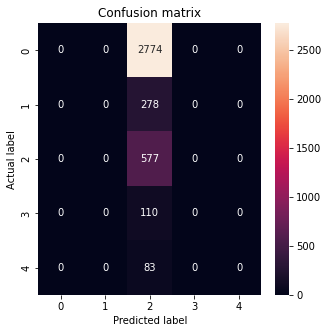

In [ ]:
eval_df=model_eval2(model3Wt, 3, 'model3-CNN Weighted', test, val)

## Transfer Learning

In [ ]:
!pip install --upgrade tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mobilenet V2

trained on (train1, train_2, train_3, train_4)

In [ ]:
feature_extractor='https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [ ]:
feature_extractor_layer=hub.KerasLayer(feature_extractor, input_shape=(224,224,3))

In [ ]:
feature_extractor_layer.trainable=False

In [ ]:
model4_tl=Sequential()

model4_tl.add(feature_extractor_layer)

model4_tl.add(Dropout(0.3))

model4_tl.add(Dense(5, activation='softmax'))


model4_tl.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
              )


In [ ]:
model4_tl.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history_model4_tl = model4_tl.fit(train,
                            validation_data=val,
                            epochs=10,
                            verbose=1,
                            class_weight = weights_dict_master                          
                            )

model4_tl.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_tl.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_tl_history.pkl','wb') as model_history:
  pkl.dump(history_model4_tl, model_history)

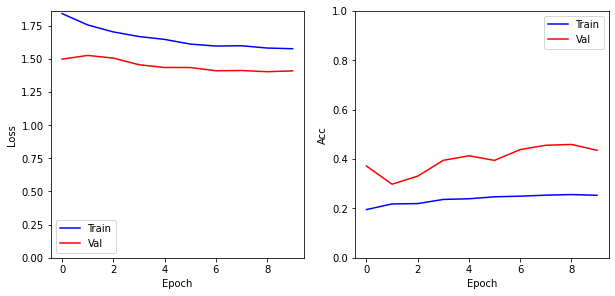

In [ ]:
plot_history(history_model4_tl)

-----TEST--------
8/8 [==============================] - 10s 1s/step - loss: 1.4090 - acc: 0.4296
loss :  1.4089561700820923
acc :  0.4296180009841919
-------------
-----VAL--------
12/12 [==============================] - 14s 1s/step - loss: 1.4093 - acc: 0.4352
loss :  1.409279465675354
acc :  0.4352044463157654
-------------
8/8 [==============================] - 10s 1s/step
3822
tf.Tensor(
[[1494  628   70  100  482]
 [ 121   93   12   18   34]
 [ 230  119   18   45  165]
 [  37   22    4   13   34]
 [  35   16    5    3   24]], shape=(5, 5), dtype=int32)
              precision    recall  f1-score   support

           0       0.78      0.54      0.64      2774
           1       0.11      0.33      0.16       278
           2       0.17      0.03      0.05       577
           3       0.07      0.12      0.09       110
           4       0.03      0.29      0.06        83

    accuracy                           0.43      3822
   macro avg       0.23      0.26      0.20      3822


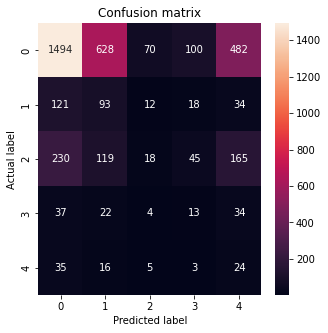

In [ ]:
model_eval2(model4_tl, 'model4_MN-CNN', test, val)

### Mobile Net for more epochs ??

In [ ]:
es=EarlyStopping( 
    verbose=1,
    patience=5,
   )

history_model4_tl2 = model4_tl.fit(train,
                            validation_data=val,
                            epochs=50,
                            verbose=1,
                            class_weight = weights_dict_master,
                            callbacks=[es]                       
                            )

model4_tl.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_tl2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_tl2_history.pkl','wb') as model_history:
  pkl.dump(history_model4_tl2, model_history)

Epoch 1/50
12/46 [======>.......................] - ETA: 36s - loss: 1.5854 - acc: 0.2860

KeyboardInterrupt: ignored

## VGG 16 with whole train dataset

Code adapted from https://github.com/krishnaik06/Transfer-Learning/blob/master/face_Recognition.py

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

In [ ]:
vgg16 = VGG16(input_shape=[224,224] + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg16.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg16.output)

prediction = Dense(5, activation='softmax')(x)

model5_vgg = Model(inputs=vgg16.input, outputs=prediction)

model5_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model5_vgg.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS,
              )


In [ ]:
es=EarlyStopping( 
    verbose=1,
    patience=5,
   )

history_model5_vgg = model5_vgg.fit(train,
                            validation_data=val,
                            epochs=30,
                            verbose=1,
                            # class_weight=weights_dict_master,
                            callbacks=[es]                            
                            )

model5_vgg.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_vgg.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_vgg_history.pkl','wb') as model_history:
  pkl.dump(history_model5_vgg, model_history)

In [ ]:
model5_vgg=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_vgg.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_vgg_history.pkl','rb') as model_history:
  history_model5_vgg=pkl.load( model_history)

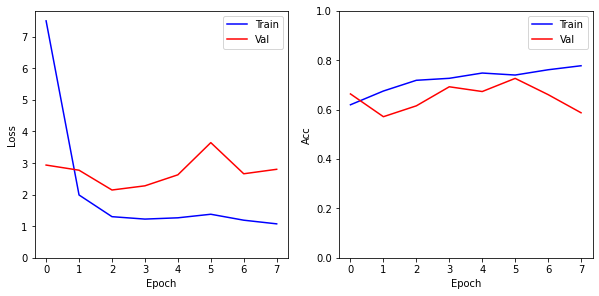

In [ ]:
plot_history(history_model5_vgg)

-----TEST--------
8/8 [==============================] - 501s 62s/step - loss: 2.9774 - acc: 0.5675
loss :  2.977372646331787
acc :  0.5675039291381836
-------------
-----VAL--------
12/12 [==============================] - 764s 63s/step - loss: 2.8010 - acc: 0.5871
loss :  2.8010425567626953
acc :  0.5871448516845703
-------------
8/8 [==============================] - 493s 61s/step
3822
              precision    recall  f1-score   support

           0       0.80      0.68      0.73      2774
           1       0.09      0.14      0.11       278
           2       0.26      0.35      0.30       577
           3       0.17      0.35      0.23       110
           4       0.42      0.10      0.16        83

    accuracy                           0.57      3822
   macro avg       0.35      0.32      0.31      3822
weighted avg       0.64      0.57      0.59      3822



,class,precision,recall,f1-score,support,model_no,comment
0,0,0.725798,1.000000,0.841116,2774.000000,1,CNN2 whole dataset
1,1,0.000000,0.000000,0.000000,278.000000,1,CNN2 whole dataset
2,2,0.000000,0.000000,0.000000,577.000000,1,CNN2 whole dataset
3,3,0.000000,0.000000,0.000000,110.000000,1,CNN2 whole dataset
4,4,0.000000,0.000000,0.000000,83.000000,1,CNN2 whole dataset
5,accuracy,0.725798,0.725798,0.725798,0.725798,1,CNN2 whole dataset
6,macro avg,0.145160,0.200000,0.168223,3822.000000,1,CNN2 whole dataset
7,weighted avg,0.526783,0.725798,0.610480,3822.000000,1,CNN2 whole dataset
8,0,0.725798,1.000000,0.841116,2774.000000,2,CNN2 more layers
9,1,0.000000,0.000000,0.000000,278.000000,2,CNN2 more layers


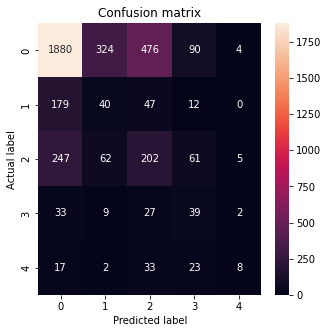

In [ ]:
model_eval2(model5_vgg,5, 'model5-tl-VGG16', test, val)

### VGG16 weighted

In [ ]:
es=EarlyStopping( 
    verbose=1,
    patience=5,
   )

history_model5_vggWt = model5_vgg.fit(train,
                            validation_data=val,
                            epochs=30,
                            verbose=1,
                            class_weight=weights_dict_master,
                            callbacks=[es]                            
                            )

model5_vgg.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_vggWt.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_vggWt_history.pkl','wb') as model_history:
  pkl.dump(history_model5_vggWt, model_history)

In [ ]:
model5_vgg=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_vggWt.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_vggWt_history.pkl','rb') as model_history:
  history_model5_vggWt=pkl.load(model_history)

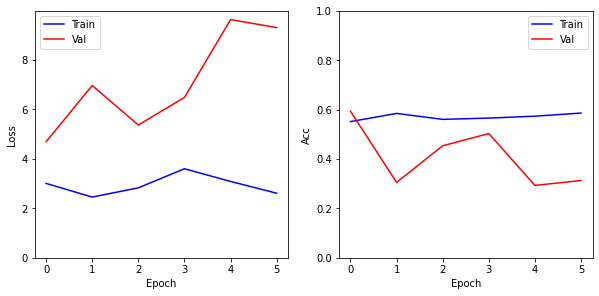

In [ ]:
plot_history(history_model5_vggWt)

-----TEST--------
8/8 [==============================] - 511s 63s/step - loss: 9.6176 - acc: 0.3250
loss :  9.61762809753418
acc :  0.32496076822280884
-------------
-----VAL--------
12/12 [==============================] - 757s 63s/step - loss: 9.2987 - acc: 0.3127
loss :  9.298741340637207
acc :  0.3127165734767914
-------------
8/8 [==============================] - 507s 63s/step
3822


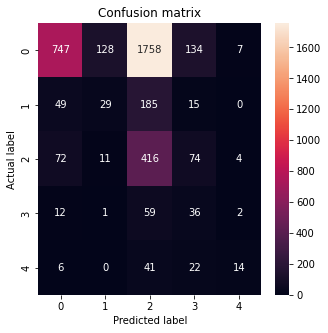

              precision    recall  f1-score   support

           0       0.84      0.27      0.41      2774
           1       0.17      0.10      0.13       278
           2       0.17      0.72      0.27       577
           3       0.13      0.33      0.18       110
           4       0.52      0.17      0.25        83

    accuracy                           0.32      3822
   macro avg       0.37      0.32      0.25      3822
weighted avg       0.66      0.32      0.36      3822



,class,precision,recall,f1-score,support,model_no,comment
0,0,0.725798,1.000000,0.841116,2774.000000,1,CNN2 whole dataset
1,1,0.000000,0.000000,0.000000,278.000000,1,CNN2 whole dataset
2,2,0.000000,0.000000,0.000000,577.000000,1,CNN2 whole dataset
3,3,0.000000,0.000000,0.000000,110.000000,1,CNN2 whole dataset
4,4,0.000000,0.000000,0.000000,83.000000,1,CNN2 whole dataset
5,accuracy,0.725798,0.725798,0.725798,0.725798,1,CNN2 whole dataset
6,macro avg,0.145160,0.200000,0.168223,3822.000000,1,CNN2 whole dataset
7,weighted avg,0.526783,0.725798,0.610480,3822.000000,1,CNN2 whole dataset
8,0,0.725798,1.000000,0.841116,2774.000000,2,CNN2 more layers
9,1,0.000000,0.000000,0.000000,278.000000,2,CNN2 more layers


In [ ]:
model_eval2(model5_vgg, 6, 'model5-tl-VGG16 Wt', test, val)

### VGG16 wighted 2 ??

In [ ]:
es=EarlyStopping( 
    verbose=1,
    patience=5,
   )

x = keras.layers.GlobalAveragePooling2D()(vgg16.output)

prediction = Dense(5, activation='softmax')(x)

model5_vgg = Model(inputs=vgg16.input, outputs=prediction)

model5_vgg.summary()


history_model5_vggWt2 = model5_vgg.fit(train,
                            validation_data=val,
                            epochs=30,
                            verbose=1,
                            class_weight=get_weights(train),
                            callbacks=[es]                            
                            )

model5_vgg.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_vggWt2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_vggWt2_history.pkl','wb') as model_history:
  pkl.dump(history_model5_vggWt2, model_history)

### VGG with more layers and batch normalization layers - trainables??

In [ ]:
# https://datascience.stackexchange.com/questions/47966/over-fitting-in-transfer-learning-with-small-dataset
#https://datascience.stackexchange.com/questions/47966/over-fitting-in-transfer-learning-with-small-dataset

vgg16 = VGG16(input_shape=[224,224] + [3], weights='imagenet', include_top=False)
vgg16.trainable = False

# un-freeze the BatchNorm layers
for layer in vgg16.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

x1 = Flatten()(vgg16.output)
x2 = Dense(512, activation='relu')(x1)
x3=Dropout(0.5)(x2)
# x4 = Dense(256, activation='relu')(x3)
# x5=Dropout(0.5)(x4)
prediction = Dense(5, activation='softmax')(x3)

# create a model object
model6_vgg = Model(inputs=vgg16.input, outputs=prediction)

model6_vgg.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS,
              )


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# view the structure of the model
model6_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
history_model6_vgg = model6_vgg.fit(train,
                            validation_data=val,
                            epochs=50,
                            verbose=1                            
                            )

model6_vgg.save('/content/drive/MyDrive/GA/Capstone/model6_vgg.h5')

with open('/content/drive/MyDrive/GA/Capstone/model6_vgg_history.pkl','wb') as model_history:
  pkl.dump(history_model6_vgg, model_history)

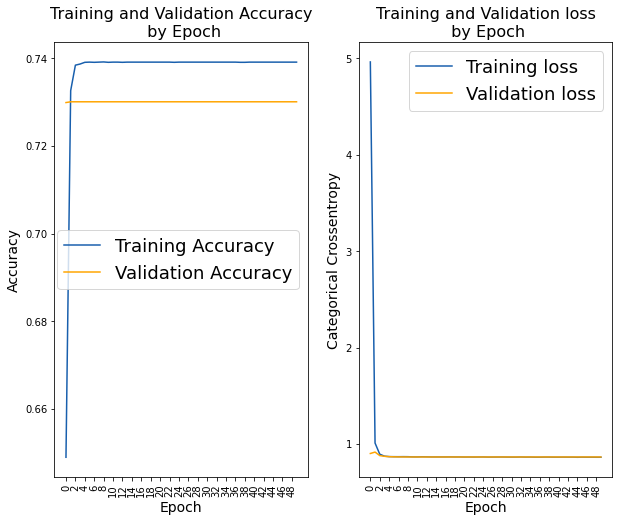

In [ ]:
loss_plot(history_model6_vgg)   

In [ ]:
model_eval(model6_vgg, 'model6 VGG with more layers(trainable')

15/15 [==============================] - 7s 477ms/step - loss: 0.8958 - accuracy: 0.7258
model6 VGG with more layers(trainable, train loss: 0.8602662086486816
model6 VGG with more layers(trainable, train accuracy: 0.7391285300254822
model6 VGG with more layers(trainable, val loss: 0.8658744096755981
model6 VGG with more layers(trainable, val accuracy: 0.730076253414154
model6 VGG with more layers(trainable, test loss: 0.8957808613777161
model6 VGG with more layers(trainable, test accuracy: 0.7257980108261108
15/15 [==============================] - 7s 471ms/step
tf.Tensor(
[[2774    0    0    0    0]
 [ 278    0    0    0    0]
 [ 577    0    0    0    0]
 [ 110    0    0    0    0]
 [  83    0    0    0    0]], shape=(5, 5), dtype=int32)
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      2774
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### VGG16 with more layers ??





In [ ]:
es=EarlyStopping(patience=5)

vgg16 = VGG16(input_shape=[224,224] + [3], weights='imagenet', include_top=False)
vgg16.trainable = False

# # un-freeze the BatchNorm layers
# for layer in vgg16.layers:
#     if "BatchNormalization" in layer.__class__.__name__:
#         layer.trainable = True

x1 = Flatten()(vgg16.output)
x2 = Dense(512, activation='relu')(x1)
x3=Dropout(0.5)(x2)
x4 = Dense(256, activation='relu')(x3)
x5=Dropout(0.5)(x4)
prediction = Dense(5, activation='softmax')(x5)

# create a model object
model7_vgg = Model(inputs=vgg16.input, outputs=prediction)

model7_vgg.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],
              )

In [ ]:
history_model7_vgg = model7_vgg.fit(train,
                            validation_data=val,
                            epochs=30,
                            callbacks=[es],
                            verbose=0,
                            class_weight={0:1.,
                                          1:4.92,
                                          2:10.77,
                                          3:29.84,
                                          4:37.76}                            
                            )

model7_vgg.save('/content/drive/MyDrive/GA/Capstone/model7_vgg.h5')

with open('/content/drive/MyDrive/GA/Capstone/model7_vgg_history.pkl','wb') as model_history:
  pkl.dump(history_model7_vgg, model_history)

In [ ]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',np.unique(train_label_df['label'].to_numpy()),train_label_df['label'].to_numpy())
# class_weights


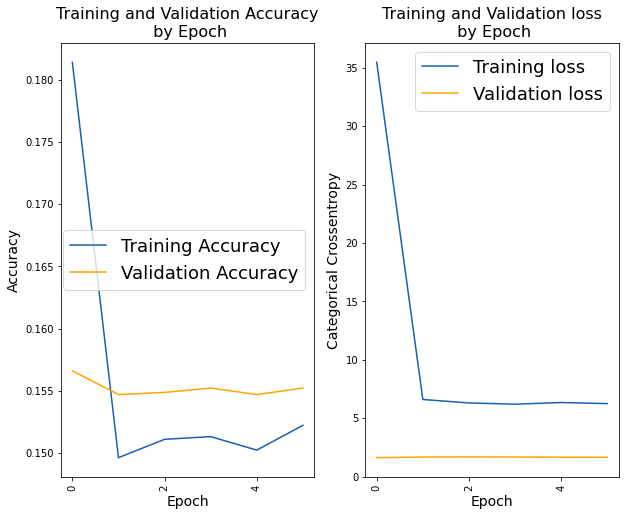

In [ ]:
loss_plot(history_model7_vgg)

In [ ]:
model_eval(model7_vgg,'model7 VGG')

15/15 [==============================] - 7s 490ms/step - loss: 0.8955 - accuracy: 0.7258
model7 VGG, train loss: 0.8595089912414551
model7 VGG, train accuracy: 0.7391718626022339
model7 VGG, val loss: 0.8661012053489685
model7 VGG, val accuracy: 0.730076253414154
model7 VGG, test loss: 0.8955405354499817
model7 VGG, test accuracy: 0.7257980108261108
15/15 [==============================] - 7s 475ms/step
tf.Tensor(
[[2774    0    0    0    0]
 [ 278    0    0    0    0]
 [ 577    0    0    0    0]
 [ 110    0    0    0    0]
 [  83    0    0    0    0]], shape=(5, 5), dtype=int32)
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      2774
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        83

    accuracy                           0.73      3822
   macro avg       0.15      0.20

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ResNet 50 with whole train dataset??

# Data Augmentation and Modeling

## Data augmentation within model

Trying models with data augemntation for smaller subset of training data.  
The data has been sorted in 5 different folders.   
class 0 has 4000 images  
class 1 has 1976 images  
class 2 has 4327 images  
class 3 has 713 images  
class4 has 565 images  

In [ ]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

#creating train and val batches 

data_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation'
IMG_height = 224
IMG_width = 224
batch_size=64


train_da = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels='inferred',
  label_mode='int',
  # class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="training",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=True)
 
val_da = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels='inferred',
  label_mode='int',
  # class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="validation",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=True)


Found 23102 files belonging to 5 classes.
Using 18482 files for training.
Found 23102 files belonging to 5 classes.
Using 4620 files for validation.


In [ ]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

# creating test batch

data_dir='/content/drive/MyDrive/GA/Capstone/test_train_3/test_reshapedImg_parent'
IMG_height = 224
IMG_width = 224
batch_size=64


test_da = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=test_label_df['label'].to_numpy().tolist(),
  label_mode='int',
  validation_split=0.0,
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)

Found 3822 files belonging to 1 classes.


In [ ]:
#https://medium.com/featurepreneur/data-augmentation-using-keras-preprocessing-layers-6cdc7d49328e

data_aug = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
# def augment (train):
#   for image, label in train:
#     if (label==1 or label==3 or label==4) :
#       image.map(data_aug)



### Baseline Accuracy

In [39]:
train_da_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/data_aug_count.csv')

In [40]:
train_da_df

,class,count,count_normalized
0,0,4000,0.345393
1,1,1976,0.170624
2,2,4327,0.373629
3,3,713,0.061566
4,4,565,0.048787


In [44]:
small_dataset_baseline=0.37

Baseline accuracy for this dataset is 0.37

### CNN1 with data augmentation 

In [ ]:
es=EarlyStopping(patience=10)

model1_da=Sequential()

# Add a convolutional layer.

model1_da.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))
model1_da.add(data_aug)

model1_da.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_da.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_da.add(MaxPooling2D(pool_size=(2, 2)))

model1_da.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_da.add(MaxPooling2D(pool_size=(2,2)))

model1_da.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model1_da.add(MaxPooling2D(pool_size=(2,2)))


model1_da.add(Flatten())


model1_da.add(Dense(128,
                activation='relu'))
model1_da.add(Dropout(0.5))


model1_da.add(Dense(256,
                activation='relu'))
model1_da.add(Dropout(0.5))


model1_da.add(Dense(5,
                 activation='softmax'))


model1_da.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=tf.keras.metrics.CategoricalAccuracy(name='acc')
              )

In [ ]:
history_model1_da = model1_da.fit(train_da,
                            validation_data=val_da,
                            epochs=10,
                            # callbacks=[es],
                            verbose=1,
                            callbacks=[es]
                            )   


model1_da.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_da.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_da_history.pkl','wb') as model_history:
  pkl.dump(history_model1_da, model_history)

In [ ]:
model1_da=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_da.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_da_history.pkl','rb') as model_history:
  history_model1_da=pkl.load( model_history)

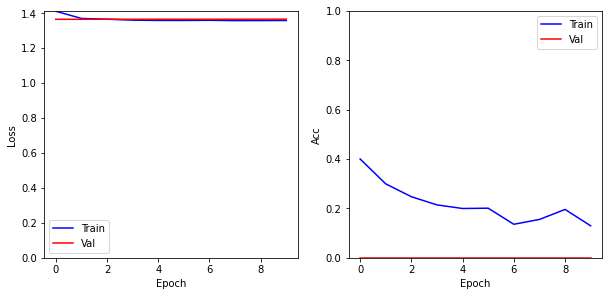

In [ ]:
plot_history(history_model1_da)

-----TEST--------
60/60 [==============================] - 140s 2s/step - loss: 1.1957 - acc: 0.0000e+00
loss :  1.1956944465637207
acc :  0.0
-------------
-----VAL--------
73/73 [==============================] - 188s 2s/step - loss: 1.9642 - acc: 0.0000e+00
loss :  1.9641880989074707
acc :  0.0
-------------
60/60 [==============================] - 137s 2s/step
3822


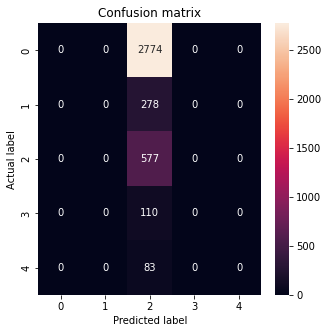

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2774
           1       0.00      0.00      0.00       278
           2       0.15      1.00      0.26       577
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        83

    accuracy                           0.15      3822
   macro avg       0.03      0.20      0.05      3822
weighted avg       0.02      0.15      0.04      3822



In [ ]:
eval_df=model_eval2(model1_da, 7, 'CNN with Data Augmentation', test_da, val_da)

### CNN2 with data augmentation

In [ ]:
model2_da=Sequential()

# Add a convolutional layer.

model2_da.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))
model2_da.add(data_aug)

model2_da.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model2_da.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model2_da.add(MaxPooling2D(pool_size=(2, 2)))


model2_da.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model2_da.add(Conv2D(128,
                  kernel_size = (3, 3),
                  activation='relu'))
model2_da.add(Conv2D(128,
                  kernel_size = (1, 1),
                  activation='relu'))
model2_da.add(MaxPooling2D(pool_size=(2,2)))



model2_da.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model2_da.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model2_da.add(Conv2D(256,
                  kernel_size = (1, 1),
                  activation='relu'))
model2_da.add(MaxPooling2D(pool_size=(2,2)))




model2_da.add(Flatten())


model2_da.add(Dense(128,
                activation='relu', kernel_regularizer=l2(0.005)))
model2_da.add(Dropout(0.5))


model2_da.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model2_da.add(Dropout(0.5))


model2_da.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model2_da.add(Dropout(0.5))


model2_da.add(Dense(5,
                 activation='softmax'
               ))


model2_da.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS
              )

In [ ]:
type(weights_dict_master)

dict

In [ ]:
history_model2_daWt = model2_da.fit(train_da,
                            validation_data=val_da,
                            epochs=10,
                            verbose=1,
                            callbacks=[es],
                            class_weight=weights_dict_master
                             )


model2_da.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_daWt.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_daWt_history.pkl','wb') as model_history:
  pkl.dump(history_model2_daWt, model_history)


In [ ]:


model2_da=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_da.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_da_history.pkl','rb') as model_history:
  history_model2_da=pkl.load(model_history)

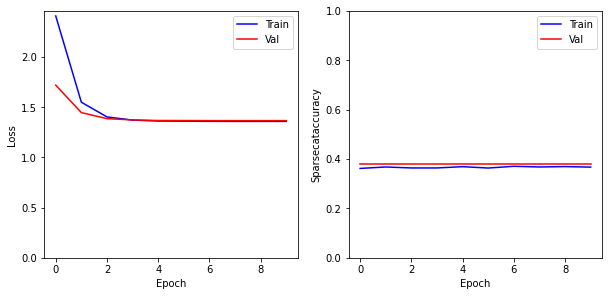

In [ ]:
plot_history(history_model2_da)

-----TEST--------
60/60 [==============================] - 321s 5s/step - loss: 1.1950 - SparseCatAccuracy: 0.1510
loss :  1.1950292587280273
SparseCatAccuracy :  0.15096807479858398
-------------
-----VAL--------
73/73 [==============================] - 17s 233ms/step - loss: 1.9552 - SparseCatAccuracy: 0.1946
loss :  1.9551736116409302
SparseCatAccuracy :  0.19458875060081482
-------------
60/60 [==============================] - 14s 228ms/step
3822
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2774
           1       0.00      0.00      0.00       278
           2       0.15      1.00      0.26       577
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        83

    accuracy                           0.15      3822
   macro avg       0.03      0.20      0.05      3822
weighted avg       0.02      0.15      0.04      3822



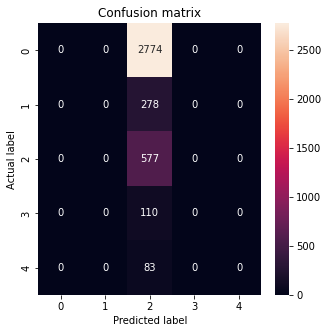

In [ ]:
eval_df=model_eval2(model2_da, 8, 'CNN2 with Data Augmentation', test_da, val_da)

### CNN2 with data augmentation - weightetd

In [ ]:

model2_daWt=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_daWt.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_daWt_history.pkl','rb') as model_history:
  history_model2_daWt=pkl.load(model_history)

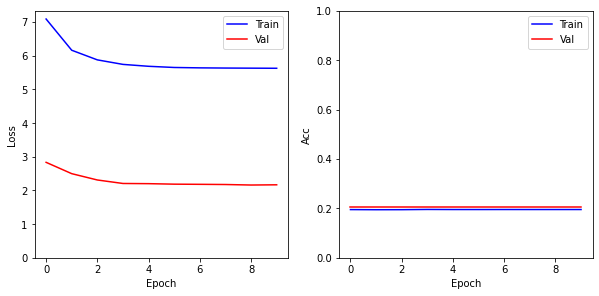

In [ ]:
plot_history(history_model2_daWt)

-----TEST--------
60/60 [==============================] - 14s 234ms/step - loss: 3.9355 - acc: 0.0217
loss :  3.9354918003082275
acc :  0.02171637862920761
-------------
-----VAL--------
73/73 [==============================] - 17s 230ms/step - loss: 2.1666 - acc: 0.2074
loss :  2.166588544845581
acc :  0.20735931396484375
-------------
60/60 [==============================] - 13s 225ms/step
3822
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2774
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00      0.00       110
           4       0.02      1.00      0.04        83

    accuracy                           0.02      3822
   macro avg       0.00      0.20      0.01      3822
weighted avg       0.00      0.02      0.00      3822



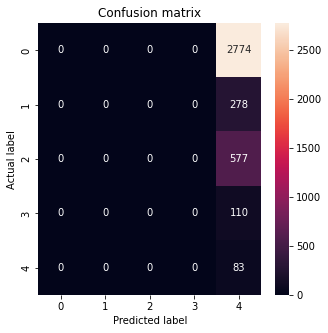

In [ ]:
eval_df=model_eval2(model2_daWt, 9, 'CNN2 with Data Augmentation-Wt', test_da, val_da)

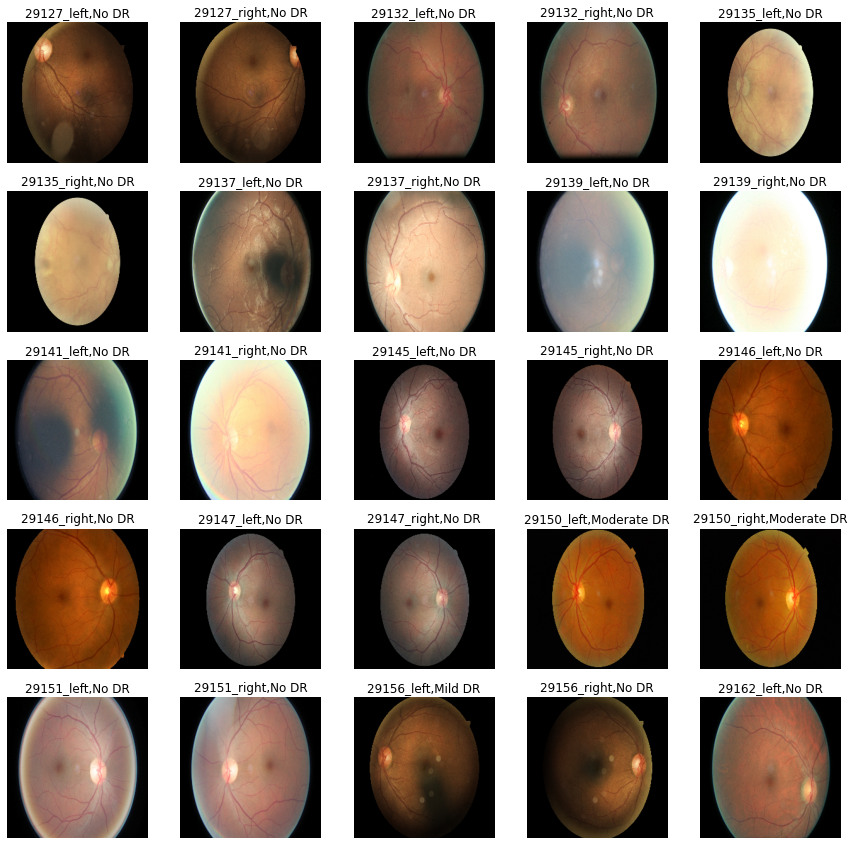

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_da.take(1):
  file_paths = test_da.file_paths
  lbl=labels.numpy()
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{str(file_paths[i].rsplit('.',1)[0].rsplit('_',1)[0].rsplit('/',1)[1])},{index_to_level[lbl[i]]}")
    plt.axis("off")

It seems the models are not learning anything, giving same prediction for each image.

## Modeling with Augmented Dataset

(~4000 images for each class)

In [19]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

#creating train and val batches 

data_dir='/content/drive/MyDrive/GA/Capstone/train_augmentation'
IMG_height = 224
IMG_width = 224
batch_size=256


train_ad = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels='inferred',
  label_mode='int',
  class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="training",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=True)
 
val_ad = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels='inferred',
  label_mode='int',
  class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="validation",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=True)


Found 23102 files belonging to 5 classes.
Using 18482 files for training.
Found 23102 files belonging to 5 classes.
Using 4620 files for validation.


In [20]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

# creating test batch

data_dir='/content/drive/MyDrive/GA/Capstone/test_train_3/test_reshapedImg_parent'
IMG_height = 224
IMG_width = 224
batch_size=256


test_ad = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=test_label_df['label'].to_numpy().tolist(),
  label_mode='int',
  validation_split=0.0,
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)

Found 3822 files belonging to 1 classes.


In [ ]:
METRICS = [      
      # keras.metrics.FalseNegatives(name='fn')
      # keras.metrics.AUC(name='auc'),
      tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
]

In [21]:
es=EarlyStopping( 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

### Baseline Accuracy

In [5]:
train_augd_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/augmented_data_count.csv')

In [7]:
train_augd_df

,class,count,count_normalized
0,0,4000,0.173145
1,1,5928,0.256601
2,2,4327,0.187300
3,3,4278,0.185179
4,4,4569,0.197775


In [11]:
augmented_dataset_baseline=0.26

Baseline accuracy for models with augmented data is 0.26

### CNN1 with augmented data

In [ ]:
model1_augd=Sequential()



model1_augd.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))


model1_augd.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
 
model1_augd.add(MaxPooling2D(pool_size=(2, 2)))


model1_augd.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 

model1_augd.add(MaxPooling2D(pool_size=(2,2)))



model1_augd.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))

model1_augd.add(MaxPooling2D(pool_size=(2,2)))




model1_augd.add(Flatten())


model1_augd.add(Dense(128,
                activation='relu'))



model1_augd.add(Dense(256,
                activation='relu'))



model1_augd.add(Dense(256,
                activation='relu'))



model1_augd.add(Dense(5,
                 activation='softmax'
               ))


model1_augd.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
              )

In [ ]:
history_model1_augd = model1_augd.fit(train_ad,
                            validation_data=val_ad,
                            epochs=10,
                            verbose=1,
                            # callbacks=[es],
                            # class_weight=weights_dict_master
                             )


model1_augd.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_augd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_augd_history.pkl','wb') as model_history:
  pkl.dump(history_model1_augd, model_history)

In [ ]:

model1_augd=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_augd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_augd_history.pkl','rb') as model_history:
  history_model1_augd=pkl.load(model_history)

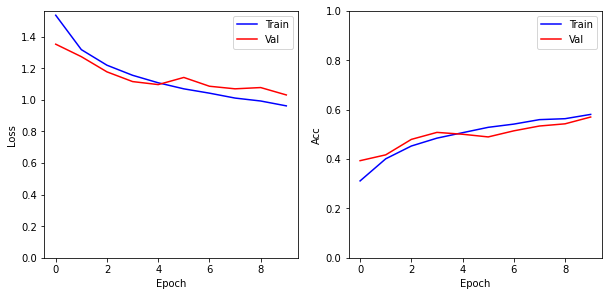

In [ ]:
plot_history(history_model1_augd)

-----TEST--------
15/15 [==============================] - 7s 425ms/step - loss: 1.1302 - acc: 0.5578
loss :  1.1302374601364136
acc :  0.557823121547699
-------------
-----VAL--------
19/19 [==============================] - 9s 383ms/step - loss: 1.0305 - acc: 0.5699
loss :  1.0305135250091553
acc :  0.5699134469032288
-------------
15/15 [==============================] - 6s 414ms/step
3822
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      2774
           1       0.09      0.03      0.05       278
           2       0.22      0.50      0.31       577
           3       0.06      0.04      0.05       110
           4       0.09      0.06      0.07        83

    accuracy                           0.56      3822
   macro avg       0.25      0.26      0.24      3822
weighted avg       0.62      0.56      0.58      3822



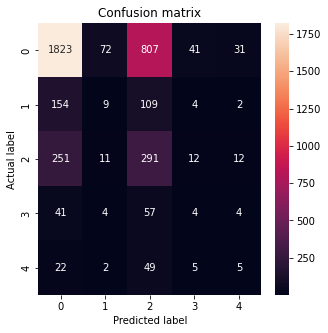

In [ ]:
eval_df=model_eval2(model1_augd, 10, 'CNN1 with augmented data', test_ad, val_ad)

### CNN1-Running model1_aug for more epochs

In [ ]:
history_model1_augd2 = model1_augd.fit(train_ad,
                            validation_data=val_ad,
                            epochs=50,
                            verbose=1,
                            callbacks=[es],
                            # class_weight=weights_dict_master
                             )


model1_augd.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_augd2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_augd2_history.pkl','wb') as model_history:
  pkl.dump(history_model1_augd2, model_history)

In [ ]:
model1_augd2=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_augd2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_augd2_history.pkl','rb') as model_history:
  history_model1_augd2=pkl.load(model_history)

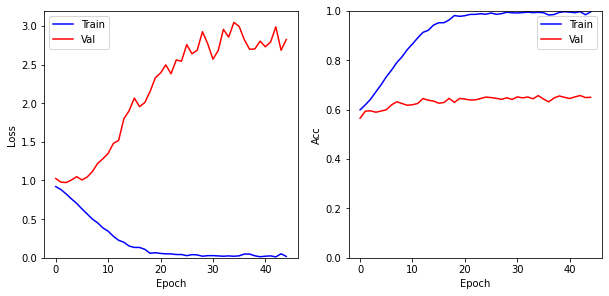

In [ ]:
plot_history(history_model1_augd2)

-----TEST--------
15/15 [==============================] - 7s 415ms/step - loss: 5.0994 - acc: 0.4563
loss :  5.0993547439575195
acc :  0.456305593252182
-------------
-----VAL--------
19/19 [==============================] - 9s 385ms/step - loss: 3.0441 - acc: 0.6565
loss :  3.044149160385132
acc :  0.6564934849739075
-------------
15/15 [==============================] - 6s 413ms/step
3822
              precision    recall  f1-score   support

           0       0.80      0.50      0.61      2774
           1       0.09      0.17      0.11       278
           2       0.21      0.50      0.29       577
           3       0.10      0.08      0.09       110
           4       0.19      0.23      0.21        83

    accuracy                           0.46      3822
   macro avg       0.28      0.29      0.26      3822
weighted avg       0.63      0.46      0.51      3822



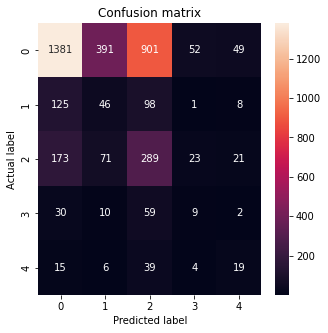

In [ ]:
eval_df=model_eval2(model1_augd2, 11, 'CNN1 with augmented data 50 epochs', test_ad, val_ad)

### CNN2 with augmented Data

In [ ]:

model2_augd=Sequential()

# Add a convolutional layer.

model2_augd.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))


model2_augd.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model2_augd.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model2_augd.add(MaxPooling2D(pool_size=(2, 2)))


model2_augd.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model2_augd.add(Conv2D(128,
                  kernel_size = (3, 3),
                  activation='relu'))
model2_augd.add(Conv2D(128,
                  kernel_size = (1, 1),
                  activation='relu'))
model2_augd.add(MaxPooling2D(pool_size=(2,2)))



model2_augd.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model2_augd.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model2_augd.add(Conv2D(256,
                  kernel_size = (1, 1),
                  activation='relu'))
model2_augd.add(MaxPooling2D(pool_size=(2,2)))




model2_augd.add(Flatten())


model2_augd.add(Dense(128,
                activation='relu'))
model2_augd.add(Dropout(0.5))


model2_augd.add(Dense(512,
                activation='relu'))
model2_augd.add(Dropout(0.5))


model2_augd.add(Dense(256,
                activation='relu'))
model2_augd.add(Dropout(0.5))


model2_augd.add(Dense(5,
                 activation='softmax'
               ))


model2_augd.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
              )

In [ ]:
history_model2_augd = model2_augd.fit(train_ad,
                            validation_data=val_ad,
                            epochs=30,
                            verbose=1,
                            callbacks=[es],
                            
                             )


model2_augd.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_augd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_augd_history.pkl','wb') as model_history:
  pkl.dump(history_model2_augd, model_history)

In [ ]:
model2_augd=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_augd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_augd_history.pkl','rb') as model_history:
  history_model2_augd=pkl.load(model_history)

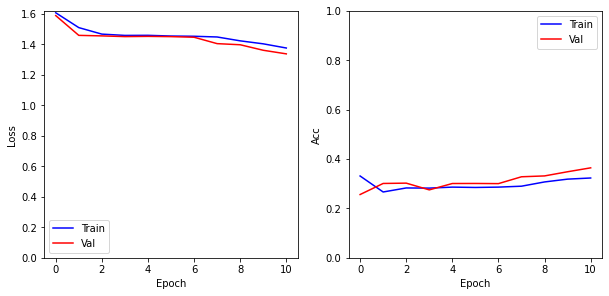

In [ ]:
plot_history(history_model2_augd)

-----TEST--------
15/15 [==============================] - 847s 55s/step - loss: 1.7211 - acc: 0.0730
loss :  1.7210835218429565
acc :  0.07299842685461044
-------------
-----VAL--------
19/19 [==============================] - 1124s 47s/step - loss: 1.5873 - acc: 0.2561
loss :  1.5872557163238525
acc :  0.2560606002807617
-------------
15/15 [==============================] - 647s 43s/step
3822
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2774
           1       0.07      1.00      0.14       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00      0.00       110
           4       0.06      0.02      0.03        83

    accuracy                           0.07      3822
   macro avg       0.03      0.20      0.03      3822
weighted avg       0.01      0.07      0.01      3822



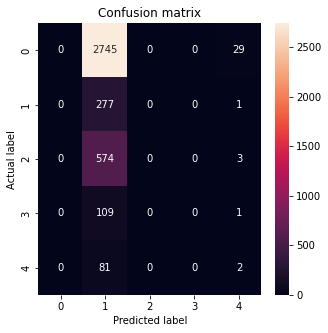

,class,precision,recall,f1-score,support,model_no,comment
0,0,0.725798,1.000000,0.841116,2774.000000,1,CNN2 whole dataset
1,1,0.000000,0.000000,0.000000,278.000000,1,CNN2 whole dataset
2,2,0.000000,0.000000,0.000000,577.000000,1,CNN2 whole dataset
3,3,0.000000,0.000000,0.000000,110.000000,1,CNN2 whole dataset
4,4,0.000000,0.000000,0.000000,83.000000,1,CNN2 whole dataset
...,...,...,...,...,...,...,...
3,3,0.000000,0.000000,0.000000,110.000000,12,CNN2 with augmented data
4,4,0.055556,0.024096,0.033613,83.000000,12,CNN2 with augmented data
5,accuracy,0.072998,0.072998,0.072998,0.072998,12,CNN2 with augmented data
6,macro avg,0.025744,0.204100,0.033986,3822.000000,12,CNN2 with augmented data


In [ ]:
model_eval2(model2_augd, 12, 'CNN2 with augmented data', test_ad, val_ad)

Running model2 with new Early Stopping

In [22]:

es=EarlyStopping( 
    verbose=1,
    patience=10,
   )


In [ ]:
history_model2_augd = model2_augd.fit(train_ad,
                            validation_data=val_ad,
                            epochs=30,
                            verbose=1,
                            callbacks=[es]
                            
                             )

In [23]:
model2_augd2=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_augd2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_augd2_history.pkl','rb') as model_history:
  history_model2_augd2=pkl.load(model_history)

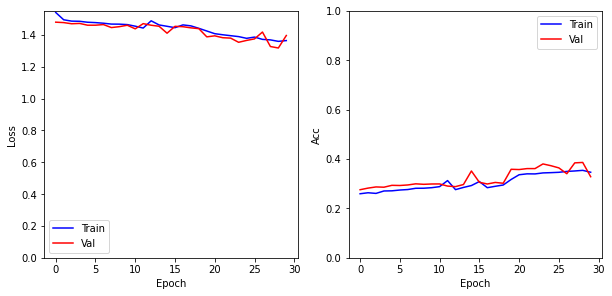

In [ ]:
plot_history(history_model2_augd)

-----TEST--------
15/15 [==============================] - 376s 23s/step - loss: 1.4353 - acc: 0.1504
loss :  1.4352645874023438
acc :  0.15044479072093964
-------------
-----VAL--------
19/19 [==============================] - 477s 13s/step - loss: 1.3957 - acc: 0.3281
loss :  1.3956912755966187
acc :  0.328138530254364
-------------
15/15 [==============================] - 13s 922ms/step
3822
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2774
           1       0.00      0.00      0.00       278
           2       0.15      1.00      0.26       577
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        83

    accuracy                           0.15      3822
   macro avg       0.03      0.20      0.05      3822
weighted avg       0.02      0.15      0.04      3822



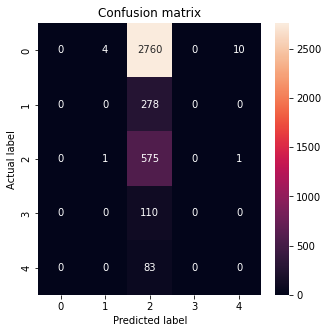

,class,precision,recall,f1-score,support,model_no,comment
0,0,0.725798,1.000000,0.841116,2774.000000,1,CNN2 whole dataset
1,1,0.000000,0.000000,0.000000,278.000000,1,CNN2 whole dataset
2,2,0.000000,0.000000,0.000000,577.000000,1,CNN2 whole dataset
3,3,0.000000,0.000000,0.000000,110.000000,1,CNN2 whole dataset
4,4,0.000000,0.000000,0.000000,83.000000,1,CNN2 whole dataset
...,...,...,...,...,...,...,...
3,3,0.000000,0.000000,0.000000,110.000000,13,CNN2 with augmented data
4,4,0.000000,0.000000,0.000000,83.000000,13,CNN2 with augmented data
5,accuracy,0.150445,0.150445,0.150445,0.150445,13,CNN2 with augmented data
6,macro avg,0.030215,0.199307,0.052475,3822.000000,13,CNN2 with augmented data


In [25]:
model_eval2(model2_augd2, 13, 'CNN2 with augmented data', test_ad, val_ad)

In [ ]:

model2_augd.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_augd2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_augd2_history.pkl','wb') as model_history:
  pkl.dump(history_model2_augd, model_history)

This model seems to be learning very slow. WE will try another variation of the first CNN model.  
Adding more layers and regularization.

### CNN3 with augmened data

In [ ]:
model3_augd=Sequential()


model3_augd.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))


model3_augd.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model3_augd.add(MaxPooling2D(pool_size=(2, 2)))


model3_augd.add(Conv2D(filters=256,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model3_augd.add(MaxPooling2D(pool_size=(2,2)))



model3_augd.add(Conv2D(512,
                  kernel_size = (3, 3),
                  activation='relu'))
model3_augd.add(MaxPooling2D(pool_size=(2,2)))



model3_augd.add(Flatten())


model3_augd.add(Dense(128,
                activation='relu'))
model3_augd.add(Dropout(0.5))


model3_augd.add(Dense(256,
                activation='relu'))
model3_augd.add(Dropout(0.5))

model3_augd.add(Dense(512,
                activation='relu'))
model3_augd.add(Dropout(0.5))

model3_augd.add(Dense(256,
                activation='relu'))
model3_augd.add(Dropout(0.5))


model3_augd.add(Dense(5,
                 activation='softmax'
               ))


model3_augd.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
              )

In [ ]:
es=EarlyStopping( 
    verbose=1,
    patience=10,
   )



In [ ]:
history_model3_augd = model3_augd.fit(train_ad,
                            validation_data=val_ad,
                            epochs=40,
                            verbose=1,
                            callbacks=[es]
                            )


model3_augd.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3_augd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3_augd_history.pkl','wb') as model_history:
  pkl.dump(history_model3_augd, model_history)

In [26]:
model3_augd=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3_augd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3_augd_history.pkl','rb') as model_history:
  history_model3_augd=pkl.load(model_history)

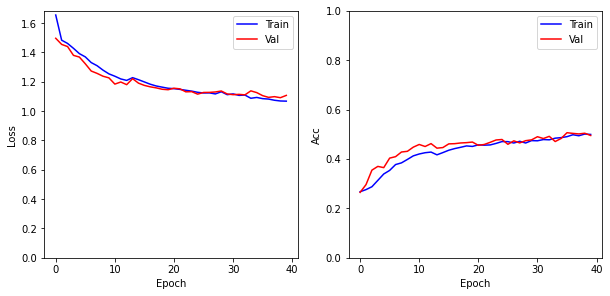

In [ ]:
plot_history(history_model3_augd)

-----TEST--------
15/15 [==============================] - 10s 661ms/step - loss: 1.1903 - acc: 0.6028
loss :  1.1903471946716309
acc :  0.6028257608413696
-------------
-----VAL--------
19/19 [==============================] - 14s 649ms/step - loss: 1.1069 - acc: 0.4950
loss :  1.1068613529205322
acc :  0.49502164125442505
-------------
15/15 [==============================] - 10s 679ms/step
3822
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      2774
           1       0.04      0.01      0.01       278
           2       0.20      0.35      0.26       577
           3       0.00      0.00      0.00       110
           4       0.50      0.01      0.02        83

    accuracy                           0.60      3822
   macro avg       0.30      0.23      0.21      3822
weighted avg       0.60      0.60      0.59      3822



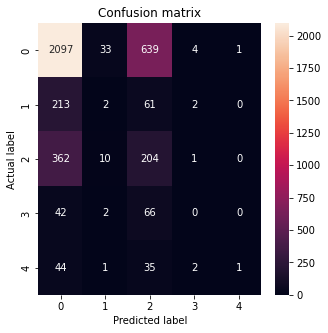

In [29]:
eval_df=model_eval2(model3_augd, 14, 'CNN3 with augmented data', test_ad, val_ad)

Runnung model3 for more epochs

In [ ]:
history_model3_augd = model3_augd.fit(train_ad,
                            validation_data=val_ad,
                            epochs=150,
                            verbose=1,
                            callbacks=[es]
                            )


model3_augd.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3_augd2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3_augd2_history.pkl','wb') as model_history:
  pkl.dump(history_model3_augd, model_history)

In [30]:
model3_augd2=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3_augd2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model3_augd2_history.pkl','rb') as model_history:
  history_model3_augd2=pkl.load(model_history)

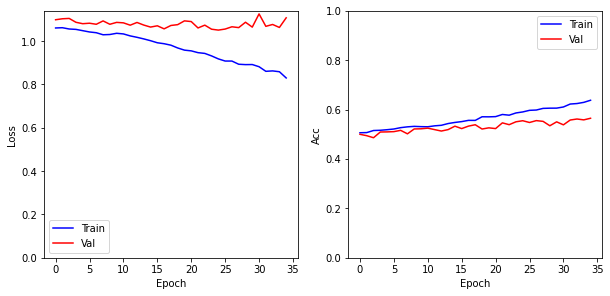

In [31]:
plot_history(history_model3_augd2)

-----TEST--------
15/15 [==============================] - 10s 675ms/step - loss: 1.2526 - acc: 0.5931
loss :  1.25257408618927
acc :  0.593144953250885
-------------
-----VAL--------
19/19 [==============================] - 20s 621ms/step - loss: 1.1078 - acc: 0.5645
loss :  1.1077836751937866
acc :  0.5645021796226501
-------------
15/15 [==============================] - 10s 665ms/step
3822
              precision    recall  f1-score   support

           0       0.78      0.73      0.76      2774
           1       0.05      0.03      0.03       278
           2       0.22      0.39      0.28       577
           3       0.10      0.05      0.06       110
           4       0.10      0.02      0.04        83

    accuracy                           0.59      3822
   macro avg       0.25      0.24      0.23      3822
weighted avg       0.61      0.59      0.60      3822



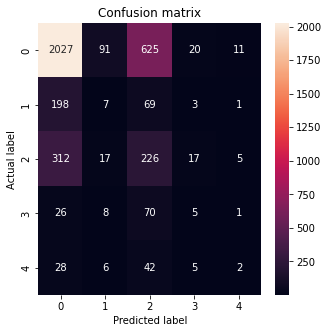

In [33]:
eval_df=model_eval2(model3_augd2, 15, 'CNN3 with augmented data-more epochs', test_ad, val_ad)

### CNN4- adding more regularization in CNN3

In [ ]:
model4_augd=Sequential()


model4_augd.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))


model4_augd.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model4_augd.add(MaxPooling2D(pool_size=(2, 2)))


model4_augd.add(Conv2D(filters=256,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model4_augd.add(MaxPooling2D(pool_size=(2,2)))



model4_augd.add(Conv2D(512,
                  kernel_size = (3, 3),
                  activation='relu'))
model4_augd.add(MaxPooling2D(pool_size=(2,2)))



model4_augd.add(Flatten())


model4_augd.add(Dense(128,
                activation='relu'))
model4_augd.add(Dropout(0.5))


model4_augd.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model4_augd.add(Dropout(0.5))

model4_augd.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.005)))
model4_augd.add(Dropout(0.5))

model4_augd.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model4_augd.add(Dropout(0.5))


model4_augd.add(Dense(5,
                 activation='softmax'
               ))


model4_augd.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
              )

In [ ]:
es=EarlyStopping( 
    verbose=1,
    patience=10,
   )



In [ ]:
history_model4_augd = model4_augd.fit(train_ad,
                            validation_data=val_ad,
                            epochs=150,
                            verbose=1,
                            callbacks=[es]
                            )


model4_augd.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd_history.pkl','wb') as model_history:
  pkl.dump(history_model4_augd, model_history)

In [34]:
model4_augd=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd_history.pkl','rb') as model_history:
  history_model4_augd=pkl.load(model_history)

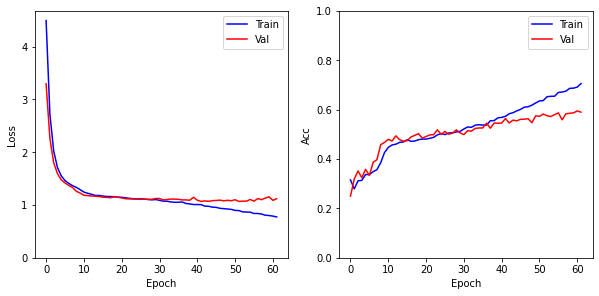

In [ ]:
plot_history(history_model4_augd)

-----TEST--------
15/15 [==============================] - 10s 663ms/step - loss: 1.3793 - acc: 0.5092
loss :  1.379256010055542
acc :  0.5091575384140015
-------------
-----VAL--------
19/19 [==============================] - 15s 620ms/step - loss: 1.1191 - acc: 0.5894
loss :  1.119146466255188
acc :  0.5893939137458801
-------------
15/15 [==============================] - 10s 663ms/step
3822
              precision    recall  f1-score   support

           0       0.81      0.58      0.67      2774
           1       0.06      0.03      0.04       278
           2       0.20      0.54      0.30       577
           3       0.12      0.13      0.13       110
           4       0.17      0.13      0.15        83

    accuracy                           0.51      3822
   macro avg       0.27      0.28      0.26      3822
weighted avg       0.63      0.51      0.54      3822



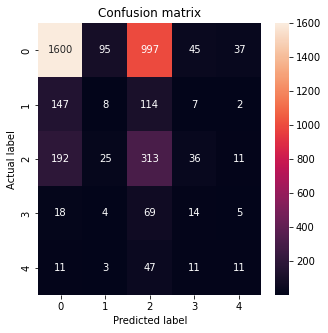

In [36]:
eval_df=model_eval2(model4_augd, 16,'CNN4 with augmented data', test_ad, val_ad)

### CNN5


Adding more layers and higher penalty with kernel and bias regularizer to model CNN 4.

In [ ]:
model5_augd=Sequential()


model5_augd.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))


model5_augd.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model5_augd.add(MaxPooling2D(pool_size=(2, 2)))


model5_augd.add(Conv2D(filters=256,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model5_augd.add(MaxPooling2D(pool_size=(2,2)))


# model5_augd.add(Conv2D(256,
#                   kernel_size = (3, 3),
#                   activation='relu'))
# model5_augd.add(MaxPooling2D(pool_size=(2,2)))


model5_augd.add(Conv2D(512,
                  kernel_size = (3, 3),
                  activation='relu'))
model5_augd.add(MaxPooling2D(pool_size=(2,2)))


model5_augd.add(Flatten())


model5_augd.add(Dense(256,
                activation='relu'))
model5_augd.add(Dropout(0.5))


model5_augd.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.0005), bias_regularizer=l2(1e-4)))
model5_augd.add(Dropout(0.5))

model5_augd.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.0005), bias_regularizer=l2(1e-4)))
model5_augd.add(Dropout(0.5))

model5_augd.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.0005), bias_regularizer=l2(1e-4)))
model5_augd.add(Dropout(0.5))


model5_augd.add(Dense(5,
                 activation='softmax'
               ))


model5_augd.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
              )

In [ ]:
es=EarlyStopping( 
    verbose=1,
    patience=10,
   )

In [ ]:
history_model5_augd = model5_augd.fit(train_ad,
                            validation_data=val_ad,
                            epochs=50,
                            verbose=1,
                            callbacks=[es]
                            )


model5_augd.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_augd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_augd_history.pkl','wb') as model_history:
  pkl.dump(history_model5_augd, model_history)

In [37]:
model5_augd=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_augd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model5_augd_history.pkl','rb') as model_history:
  history_model5_augd=pkl.load(model_history)

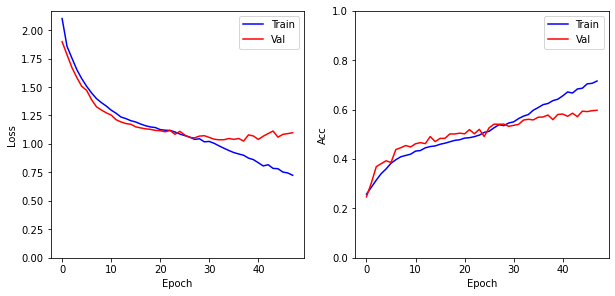

In [ ]:
plot_history(history_model5_augd)

-----TEST--------
15/15 [==============================] - 10s 654ms/step - loss: 1.4533 - acc: 0.5175
loss :  1.4533292055130005
acc :  0.517530083656311
-------------
-----VAL--------
19/19 [==============================] - 15s 614ms/step - loss: 1.0989 - acc: 0.5972
loss :  1.09892737865448
acc :  0.5971861481666565
-------------
15/15 [==============================] - 10s 664ms/step
3822
              precision    recall  f1-score   support

           0       0.80      0.60      0.68      2774
           1       0.11      0.12      0.11       278
           2       0.20      0.45      0.28       577
           3       0.18      0.14      0.15       110
           4       0.15      0.11      0.12        83

    accuracy                           0.52      3822
   macro avg       0.29      0.28      0.27      3822
weighted avg       0.62      0.52      0.55      3822



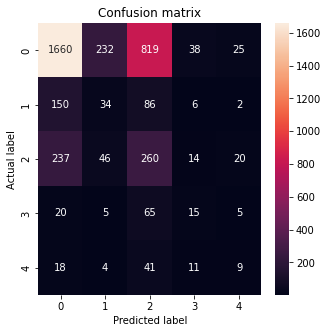

In [38]:
eval_df=model_eval2(model5_augd, 17, 'CNN5 with augmented data', test_ad, val_ad)

CNN4 with more regularization

In [ ]:
model4_augd2=Sequential()


model4_augd2.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))


model4_augd2.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model4_augd2.add(MaxPooling2D(pool_size=(2, 2)))


model4_augd2.add(Conv2D(filters=256,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model4_augd2.add(MaxPooling2D(pool_size=(2,2)))



model4_augd2.add(Conv2D(512,
                  kernel_size = (3, 3),
                  activation='relu'))
model4_augd2.add(MaxPooling2D(pool_size=(2,2)))



model4_augd2.add(Flatten())


model4_augd2.add(Dense(128,
                activation='relu'))
model4_augd2.add(Dropout(0.5))


model4_augd2.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.0005), bias_regularizer=l2(1e-4)))
model4_augd2.add(Dropout(0.5))

model4_augd2.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.005), bias_regularizer=l2(1e-4)))
model4_augd2.add(Dropout(0.5))

model4_augd2.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.0005), bias_regularizer=l2(1e-4)))
model4_augd2.add(Dropout(0.5))


model4_augd2.add(Dense(5,
                 activation='softmax'
               ))


model4_augd2.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
              )

In [ ]:
history_model4_augd2 = model4_augd2.fit(train_ad,
                            validation_data=val_ad,
                            epochs=100,
                            verbose=1,
                            callbacks=[es]
                            )


model4_augd2.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd2_history.pkl','wb') as model_history:
  pkl.dump(history_model4_augd2, model_history)

In [39]:

model4_augd2=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd2_history.pkl','rb') as model_history:
  history_model4_augd2= pkl.load(model_history)

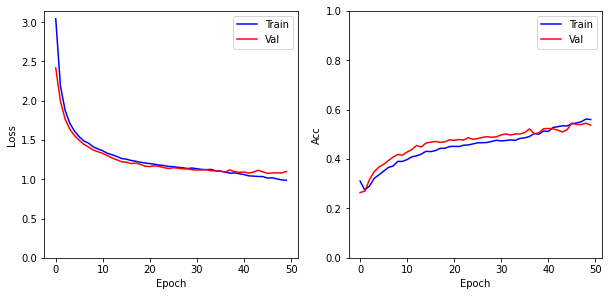

In [ ]:
plot_history(history_model4_augd2)

-----TEST--------
15/15 [==============================] - 10s 655ms/step - loss: 1.2893 - acc: 0.5816
loss :  1.289270043373108
acc :  0.581632673740387
-------------
-----VAL--------
19/19 [==============================] - 13s 610ms/step - loss: 1.0988 - acc: 0.5368
loss :  1.0988280773162842
acc :  0.536796510219574
-------------
15/15 [==============================] - 9s 654ms/step
3822
              precision    recall  f1-score   support

           0       0.78      0.71      0.75      2774
           1       0.07      0.02      0.03       278
           2       0.20      0.38      0.26       577
           3       0.14      0.13      0.13       110
           4       0.30      0.04      0.06        83

    accuracy                           0.58      3822
   macro avg       0.30      0.25      0.25      3822
weighted avg       0.61      0.58      0.59      3822



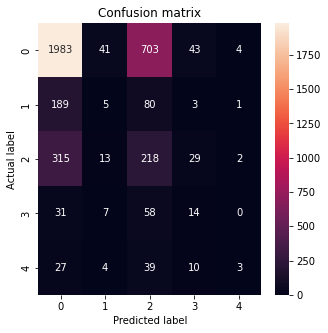

In [40]:
eval_df=model_eval2(model4_augd2, 18, 'CNN4 more regularization', test_ad, val_ad)

CNN4 with even more regularization and more epochs

In [ ]:
model4_augd3=Sequential()


model4_augd3.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))


model4_augd3.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model4_augd3.add(MaxPooling2D(pool_size=(2, 2)))


model4_augd3.add(Conv2D(filters=256,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model4_augd3.add(MaxPooling2D(pool_size=(2,2)))



model4_augd3.add(Conv2D(512,
                  kernel_size = (3, 3),
                  activation='relu'))
model4_augd3.add(MaxPooling2D(pool_size=(2,2)))



model4_augd3.add(Flatten())


model4_augd3.add(Dense(128,
                activation='relu'))
model4_augd3.add(Dropout(0.5))


model4_augd3.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(1e-4)))
model4_augd3.add(Dropout(0.5))

model4_augd3.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(1e-4)))
model4_augd3.add(Dropout(0.5))

model4_augd3.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(1e-4)))
model4_augd3.add(Dropout(0.5))


model4_augd3.add(Dense(5,
                 activation='softmax'
               ))


model4_augd3.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
              )

In [ ]:
history_model4_augd3 = model4_augd3.fit(train_ad,
                            validation_data=val_ad,
                            epochs=100,
                            verbose=1,
                            callbacks=[es]
                            )



In [ ]:

model4_augd3.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd3.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd3_history.pkl','wb') as model_history:
  pkl.dump(history_model4_augd3, model_history)

In [41]:

model4_augd3=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd3.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model4_augd3_history.pkl','rb') as model_history:
  history_model4_augd3= pkl.load(model_history)

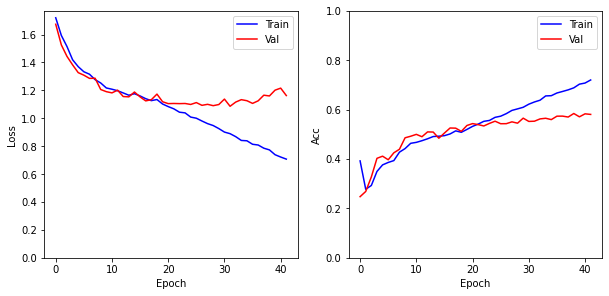

In [ ]:
plot_history(history_model4_augd3)

-----TEST--------
15/15 [==============================] - 10s 652ms/step - loss: 1.3668 - acc: 0.5290
loss :  1.3668124675750732
acc :  0.5290423631668091
-------------
-----VAL--------
19/19 [==============================] - 13s 611ms/step - loss: 1.1625 - acc: 0.5805
loss :  1.162527322769165
acc :  0.5805194973945618
-------------
15/15 [==============================] - 10s 661ms/step
3822
              precision    recall  f1-score   support

           0       0.77      0.63      0.70      2774
           1       0.09      0.10      0.10       278
           2       0.20      0.38      0.26       577
           3       0.09      0.06      0.08       110
           4       0.17      0.12      0.14        83

    accuracy                           0.53      3822
   macro avg       0.26      0.26      0.25      3822
weighted avg       0.60      0.53      0.56      3822



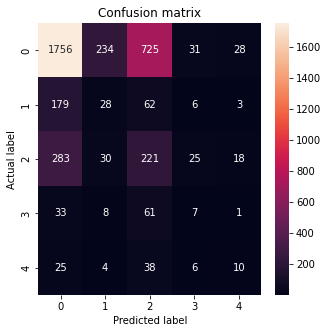

In [46]:
eval_df=model_eval2(model4_augd3, 19, 'CNN4 with even more regular. and epochs', test_ad, val_ad)

## Transfer Learning with augmented data ??

### Inception Resnet V2??

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2  
from keras.applications.inception_resnet_v2 import preprocess_input

In [ ]:
inresnet = InceptionResNetV2(input_shape=[224,224] + [3], weights='imagenet', include_top=False)


219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
for layer in inresnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(inresnet.output)

prediction = Dense(5, activation='softmax')(x)

model1_inresnet = Model(inputs=inresnet.input, outputs=prediction)

model1_inresnet.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
                    )
              
model1_inresnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
#ran with batch size=256
history_model1_inresnet =model1_inresnet.fit(train_ad,
                            validation_data=val_ad,
                            epochs=10,
                            verbose=1,
                                                 
                            )

model4b_inresnet.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet_history.pkl','wb') as model_history:
  pkl.dump(history_model4b_inresnet, model_history)

# Modeling with smaller balanced dataset
(500 images per class)

In [16]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

#creating train and val batches 

data_dir='/content/drive/MyDrive/GA/Capstone/train_500count'
IMG_height = 224
IMG_width = 224
batch_size=128


train_sd = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels='inferred',
  label_mode='int',
  class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="training",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=True)
 
val_sd = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels='inferred',
  label_mode='int',
  class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="validation",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=True)


Found 2500 files belonging to 5 classes.
Using 2000 files for training.
Found 2500 files belonging to 5 classes.
Using 500 files for validation.


In [17]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

# creating test batch

data_dir='/content/drive/MyDrive/GA/Capstone/test_train_3/test_reshapedImg_parent'
IMG_height = 224
IMG_width = 224
batch_size=128


test_sd = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=test_label_df['label'].to_numpy().tolist(),
  label_mode='int',
  validation_split=0.0,
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)

Found 3822 files belonging to 1 classes.


In [18]:
METRICS = [      
      # keras.metrics.FalseNegatives(name='fn')
      # keras.metrics.AUC(name='auc'),
      tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
]

In [19]:
es=EarlyStopping( 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

### Baseline Accuracy

In [19]:
train_sd_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/small500_data_count.csv')

In [20]:
train_sd_df

,class,count,count_normalized
0,0,500,0.2
1,1,500,0.2
2,2,500,0.2
3,3,500,0.2
4,4,500,0.2


In [42]:
small_bal_dataset_baseline=0.2

Baseline accuravy for models trained on this dataset is 0.2

### CNN1

HSV conversion

In [ ]:
#https://stackoverflow.com/questions/43033739/how-to-convert-images-color-space-in-keras
def hsv_conversion(x):
     
    return tf.image.rgb_to_hsv(x)

In [ ]:

es=EarlyStopping( 
    verbose=1,
    patience=10,
   )

model1_sd=Sequential()


model1_sd.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))
model1_sd.add(Lambda(hsv_conversion, input_shape=(IMG_height, IMG_width,3)))

model1_sd.add(Conv2D(filters=256,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_sd.add(MaxPooling2D(pool_size=(2, 2)))


model1_sd.add(Conv2D(filters=512,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_sd.add(MaxPooling2D(pool_size=(2,2)))


model1_sd.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model1_sd.add(MaxPooling2D(pool_size=(2,2)))


# model5_augd.add(Conv2D(512,
#                   kernel_size = (3, 3),
#                   activation='relu'))
# model5_augd.add(MaxPooling2D(pool_size=(2,2)))


model1_sd.add(Flatten())


model1_sd.add(Dense(256,
                activation='relu'))
model1_sd.add(Dropout(0.5))


model1_sd.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.0005), bias_regularizer=l2(1e-4)))
model1_sd.add(Dropout(0.5))

model1_sd.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.0005), bias_regularizer=l2(1e-4)))
model1_sd.add(Dropout(0.5))

# model5_augd.add(Dense(256,
#                 activation='relu', kernel_regularizer=l2(0.0005), bias_regularizer=l2(1e-4)))
# model5_augd.add(Dropout(0.5))


model1_sd.add(Dense(5,
                 activation='softmax'
               ))


model1_sd.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
              )

In [ ]:
# with batch of 128
history_model1_sd = model1_sd.fit(train_sd,
                            validation_data=val_sd,
                            epochs=50,
                            verbose=1,
                            callbacks=[es]
                            )


model1_sd.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_sd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_sd_history.pkl','wb') as model_history:
  pkl.dump(history_model1_sd, model_history)

In [20]:
model1_sd=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_sd.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_sd_history.pkl','rb') as model_history:
  history_model1_sd=pkl.load(model_history)

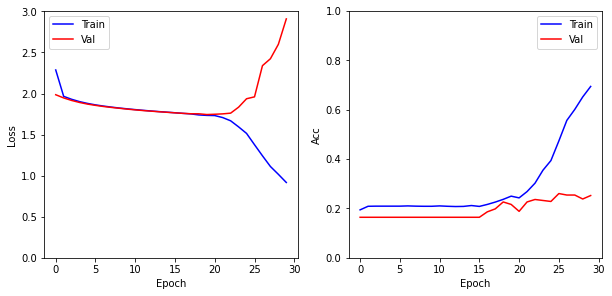

In [ ]:
plot_history(history_model1_sd)

-----TEST--------
30/30 [==============================] - 38s 808ms/step - loss: 2.7033 - acc: 0.1941
loss :  2.703286647796631
acc :  0.19413919746875763
-------------
-----VAL--------
4/4 [==============================] - 18s 633ms/step - loss: 2.9090 - acc: 0.2520
loss :  2.9090216159820557
acc :  0.25200000405311584
-------------
30/30 [==============================] - 5s 158ms/step
3822
              precision    recall  f1-score   support

           0       0.74      0.18      0.29      2774
           1       0.08      0.40      0.13       278
           2       0.18      0.18      0.18       577
           3       0.04      0.25      0.07       110
           4       0.02      0.12      0.03        83

    accuracy                           0.19      3822
   macro avg       0.21      0.23      0.14      3822
weighted avg       0.57      0.19      0.25      3822



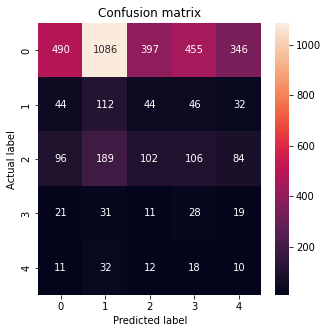

In [21]:
eval_df=model_eval2(model1_sd, 20, 'CNN1 sd', test_sd, val_sd)

### CNN2  
HSV  
data augmentation

In [ ]:
data_aug = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomFlip("horizontal_and_vertical")
  # tf.keras.layers.RandomBrightness(factor=0.3, value_range=(0.0, 1.0), seed=42)
])

In [ ]:

es=EarlyStopping( 
    verbose=1,
    patience=10,
   )

model1_sd=Sequential()

model1_sd.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))
model1_sd.add(Lambda(hsv_conversion, input_shape=(IMG_height, IMG_width,3)))
model1_sd.add(data_aug)

model1_sd.add(Conv2D(filters=256,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_sd.add(MaxPooling2D(pool_size=(2, 2)))


model1_sd.add(Conv2D(filters=512,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_sd.add(MaxPooling2D(pool_size=(2,2)))


model1_sd.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model1_sd.add(MaxPooling2D(pool_size=(2,2)))


# model5_augd.add(Conv2D(512,
#                   kernel_size = (3, 3),
#                   activation='relu'))
# model5_augd.add(MaxPooling2D(pool_size=(2,2)))


model1_sd.add(Flatten())


model1_sd.add(Dense(256,
                activation='relu'))
model1_sd.add(Dropout(0.5))


model1_sd.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.00005), bias_regularizer=l2(1e-4)))
model1_sd.add(Dropout(0.5))

model1_sd.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.00005), bias_regularizer=l2(1e-4)))
model1_sd.add(Dropout(0.5))

# model5_augd.add(Dense(256,
#                 activation='relu', kernel_regularizer=l2(0.00005), bias_regularizer=l2(1e-4)))
# model5_augd.add(Dropout(0.5))


model1_sd.add(Dense(5,
                 activation='softmax'
               ))


model1_sd.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
              )

In [ ]:
# with batch of 128
history_model1_sd2 = model1_sd.fit(train_sd,
                            validation_data=val_sd,
                            epochs=50,
                            verbose=1,
                            callbacks=[es]
                            )


model1_sd.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_sd2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_sd2_history.pkl','wb') as model_history:
  pkl.dump(history_model1_sd2, model_history)

In [22]:
model1_sd2=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_sd2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model1_sd2_history.pkl','rb') as model_history:
  history_model1_sd2=pkl.load(model_history)

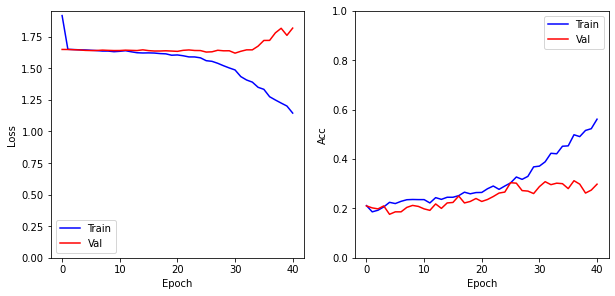

In [ ]:
plot_history(history_model1_sd2)

-----TEST--------
30/30 [==============================] - 5s 161ms/step - loss: 1.9685 - acc: 0.2360
loss :  1.9685308933258057
acc :  0.2360020875930786
-------------
-----VAL--------
4/4 [==============================] - 1s 137ms/step - loss: 1.8181 - acc: 0.2980
loss :  1.8180696964263916
acc :  0.2980000078678131
-------------
30/30 [==============================] - 5s 158ms/step
3822
              precision    recall  f1-score   support

           0       0.76      0.25      0.37      2774
           1       0.08      0.24      0.13       278
           2       0.15      0.16      0.16       577
           3       0.05      0.29      0.09       110
           4       0.02      0.25      0.04        83

    accuracy                           0.24      3822
   macro avg       0.21      0.24      0.16      3822
weighted avg       0.58      0.24      0.31      3822



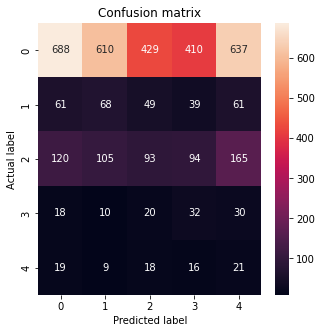

In [23]:
eval_df=model_eval2(model1_sd2, 21, 'CNN2 with small dataset & data aug', test_sd, val_sd)

### CNN2
HSV   
more data augmentation (flip and rotation)

In [ ]:
#https://stackoverflow.com/questions/43033739/how-to-convert-images-color-space-in-keras
def hsv_conversion(x):
     
    return tf.image.rgb_to_hsv(x)

In [ ]:
# def median_filter(x):
    
#     return tf.image.median_filter2d(x)

In [ ]:
# def equalize(x):
     
#     return tf.image.equalize(x)

In [ ]:
# def smooth(x):
     
#     return tf.image.gaussian_filter2d(x)

In [ ]:
data_aug = tf.keras.Sequential([
  # tf.keras.layers.RandomBrightness(factor=0.3, value_range=(0.0, 1.0), seed=42),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(factor=0.2,fill_mode="reflect",interpolation="bilinear", seed=42, fill_value=0.0),
  
])

In [ ]:

es=EarlyStopping( 
    verbose=1,
    patience=5,
   )

model2_sd=Sequential()

model2_sd.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))
model2_sd.add(Lambda(hsv_conversion, input_shape=(IMG_height, IMG_width,3)))


model2_sd.add(data_aug)

model2_sd.add(Conv2D(filters=256,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model2_sd.add(MaxPooling2D(pool_size=(2, 2)))


model2_sd.add(Conv2D(filters=256,            
                     kernel_size=(5, 5),        
                     activation='relu'    
                    )) 
model2_sd.add(MaxPooling2D(pool_size=(2,2)))


model2_sd.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model2_sd.add(MaxPooling2D(pool_size=(2,2)))


# model5_augd.add(Conv2D(512,
#                   kernel_size = (3, 3),
#                   activation='relu'))
# model5_augd.add(MaxPooling2D(pool_size=(2,2)))


model2_sd.add(Flatten())


model2_sd.add(Dense(256,
                activation='relu'))
model2_sd.add(Dropout(0.5))


model2_sd.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.00005), bias_regularizer=l2(1e-4)))
model2_sd.add(Dropout(0.5))

model2_sd.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.00005), bias_regularizer=l2(1e-4)))
model2_sd.add(Dropout(0.5))

# model5_augd.add(Dense(256,
#                 activation='relu', kernel_regularizer=l2(0.00005), bias_regularizer=l2(1e-4)))
# model5_augd.add(Dropout(0.5))


model2_sd.add(Dense(5,
                 activation='softmax'
               ))


model2_sd.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS
              )

In [ ]:
# with batch of 128
history_model2_sd2 = model2_sd.fit(train_sd,
                            validation_data=val_sd,
                            epochs=50,
                            verbose=1,
                            callbacks=[es]
                            )


model2_sd.save('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_sd2.h5')

with open('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model2_sd2_history.pkl','wb') as model_history:
  pkl.dump(history_model2_sd2, model_history)

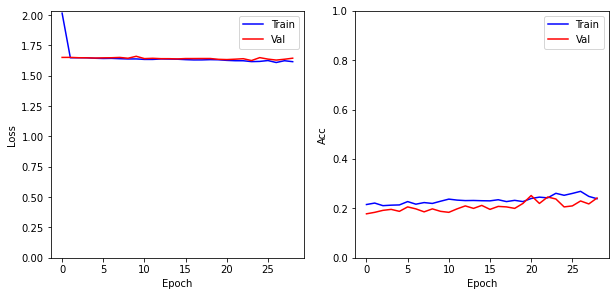

In [ ]:
plot_history(history_model2_sd2)

-----TEST--------
30/30 [==============================] - 5s 165ms/step - loss: 1.6908 - acc: 0.1395
loss :  1.6908408403396606
acc :  0.13945578038692474
-------------
-----VAL--------
4/4 [==============================] - 1s 106ms/step - loss: 1.6450 - acc: 0.2420
loss :  1.6449824571609497
acc :  0.24199999868869781
-------------
30/30 [==============================] - 4s 122ms/step
3822
tf.Tensor(
[[ 358  746   71 1230  369]
 [  31   88    6  123   30]
 [  79  118   16  274   90]
 [  13   17    2   58   20]
 [  14   19    2   35   13]], shape=(5, 5), dtype=int32)
              precision    recall  f1-score   support

           0       0.72      0.13      0.22      2774
           1       0.09      0.32      0.14       278
           2       0.16      0.03      0.05       577
           3       0.03      0.53      0.06       110
           4       0.02      0.16      0.04        83

    accuracy                           0.14      3822
   macro avg       0.21      0.23      0.10

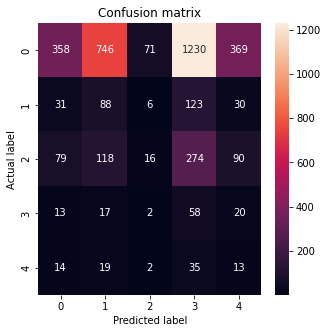

In [ ]:
model_eval2(model2_sd, 'CNN3 with small dataset', test_sd, val_sd)

# Model Evaluation

In [24]:
eval_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/MulticlassModels/model_evaluation.csv')

In [25]:
eval_df

,class,precision,recall,f1-score,support,model_no,comment
0,0,0.725798,1.00,0.841116,2774.0,1,CNN2 whole dataset
1,1,0.000000,0.00,0.000000,278.0,1,CNN2 whole dataset
2,2,0.000000,0.00,0.000000,577.0,1,CNN2 whole dataset
3,3,0.000000,0.00,0.000000,110.0,1,CNN2 whole dataset
4,4,0.000000,0.00,0.000000,83.0,1,CNN2 whole dataset
...,...,...,...,...,...,...,...
171,3,0.030000,0.53,0.060000,110.0,22,CNN2 sd-more data aug
172,4,0.020000,0.16,0.040000,83.0,22,CNN2 sd-more data aug
173,accuracy,0.140000,0.14,0.140000,3822.0,22,CNN2 sd-more data aug
174,macro avg,0.210000,0.23,0.100000,3822.0,22,CNN2 sd-more data aug


In [26]:
eval_df_t=eval_df.transpose()

In [27]:
eval_df_t

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
class,0,1,2,3,4,accuracy,macro avg,weighted avg,0,1,...,macro avg,weighted avg,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.725798,0.0,0.0,0.0,0.0,0.725798,0.14516,0.526783,0.725798,0.0,...,0.2148,0.582437,0.72,0.09,0.16,0.03,0.02,0.14,0.21,0.56
recall,1.0,0.0,0.0,0.0,0.0,0.725798,0.2,0.725798,1.0,0.0,...,0.239544,0.236002,0.13,0.32,0.03,0.53,0.16,0.14,0.23,0.14
f1-score,0.841116,0.0,0.0,0.0,0.0,0.725798,0.168223,0.61048,0.841116,0.0,...,0.158019,0.307764,0.22,0.14,0.05,0.06,0.04,0.14,0.1,0.18
support,2774.0,278.0,577.0,110.0,83.0,0.725798,3822.0,3822.0,2774.0,278.0,...,3822.0,3822.0,2774.0,278.0,577.0,110.0,83.0,3822.0,3822.0,3822.0
model_no,1,1,1,1,1,1,1,1,2,2,...,21,21,22,22,22,22,22,22,22,22
comment,CNN2 whole dataset,CNN2 whole dataset,CNN2 whole dataset,CNN2 whole dataset,CNN2 whole dataset,CNN2 whole dataset,CNN2 whole dataset,CNN2 whole dataset,CNN2 more layers,CNN2 more layers,...,CNN2 with small dataset & data aug,CNN2 with small dataset & data aug,CNN2 sd-more data aug,CNN2 sd-more data aug,CNN2 sd-more data aug,CNN2 sd-more data aug,CNN2 sd-more data aug,CNN2 sd-more data aug,CNN2 sd-more data aug,CNN2 sd-more data aug


In [37]:
eval_df_acc=eval_df[eval_df['class']=='accuracy'].copy()
eval_df_acc2=eval_df_acc.iloc[3:,:].copy()
eval_df_acc2

,class,precision,recall,f1-score,support,model_no,comment
29,accuracy,0.430000,0.430000,0.430000,3822.000000,4,model4-tl-MN
37,accuracy,0.567504,0.567504,0.567504,0.567504,5,model5-tl-VGG16
45,accuracy,0.324961,0.324961,0.324961,0.324961,6,model5-tl-VGG16 Wt
53,accuracy,0.150968,0.150968,0.150968,0.150968,7,CNN with Data Augmentation
61,accuracy,0.150968,0.150968,0.150968,0.150968,8,CNN2 with Data Augmentation
69,accuracy,0.021716,0.021716,0.021716,0.021716,9,CNN2 with Data Augmentation-Wt
77,accuracy,0.557823,0.557823,0.557823,0.557823,10,CNN1 with augmented data
85,accuracy,0.456306,0.456306,0.456306,0.456306,11,CNN1 with augmented data 50 epochs
93,accuracy,0.072998,0.072998,0.072998,0.072998,12,CNN2 with augmented data
101,accuracy,0.150445,0.150445,0.150445,0.150445,13,CNN2 with augmented data


In [38]:
eval_df_acc2=eval_df_acc2[['class','f1-score','model_no','comment']].copy()
eval_df_acc2.rename(columns={'f1-score':'SCaccuracy'}, inplace=True)
eval_df_acc2.drop(columns='class',inplace=True)
eval_df_acc2

,SCaccuracy,model_no,comment
29,0.430000,4,model4-tl-MN
37,0.567504,5,model5-tl-VGG16
45,0.324961,6,model5-tl-VGG16 Wt
53,0.150968,7,CNN with Data Augmentation
61,0.150968,8,CNN2 with Data Augmentation
69,0.021716,9,CNN2 with Data Augmentation-Wt
77,0.557823,10,CNN1 with augmented data
85,0.456306,11,CNN1 with augmented data 50 epochs
93,0.072998,12,CNN2 with augmented data
101,0.150445,13,CNN2 with augmented data


In [47]:
eval_df_acc2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 29 to 5
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   class      18 non-null     object 
 1   precision  18 non-null     float64
 2   recall     18 non-null     float64
 3   f1-score   18 non-null     float64
 4   support    18 non-null     float64
 5   model_no   18 non-null     int64  
 6   comment    18 non-null     object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.1+ KB


In [60]:
x_ticks=list(eval_df_acc2['model_no'])
x_ticks

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

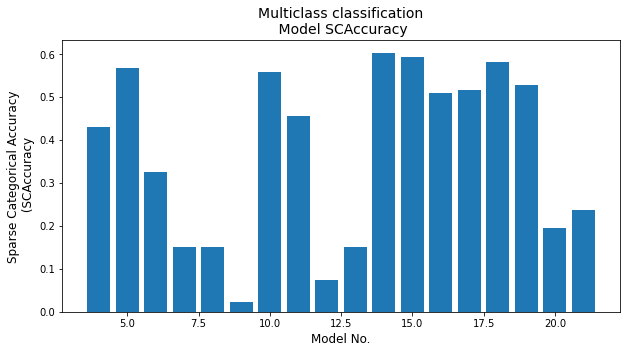

In [68]:
plt.figure(figsize=(10,5))
plt.bar(x=eval_df_acc2['model_no'], height=eval_df_acc2['f1-score']);
plt.title('Multiclass classification\n Model SCAccuracy', size=14)
plt.xlabel('Model No.', size=12)
plt.ylabel('Sparse Categorical Accuracy\n (SCAccuracy', size=12);
# plt.xticks(ticks=x_ticks, labels=x_ticks)

Baseline accuracy summary:

Whole dataset:

In [13]:
whole_dataset_baseline

0.74

Small training set (class 0-4000 , and all of class 1 through 4 (non augmented)):

In [45]:
small_dataset_baseline

0.37

Baseline for pre-augmented dataset (~4000-5000 count each class):


In [14]:
augmented_dataset_baseline

0.26

Small balanced dataset baseline (500 count each class):

In [43]:
small_bal_dataset_baseline

0.2